# Credit Card Segmentation
This is the next project I will be working on. It is a clustering problem i.e. no defined result just trying to group the entires into different categories. The premise is that a bank wants to describe its users so it can better unstand its userbase. Dataset obtained from: https://www.kaggle.com/arjunbhasin2013/ccdata

Column meanings:
CUSTID : Identification of Credit Card holder (Categorical)
BALANCE : Balance amount left in their account to make purchases (
BALANCEFREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
PURCHASES : Amount of purchases made from account
ONEOFFPURCHASES : Maximum purchase amount done in one-go
INSTALLMENTSPURCHASES : Amount of purchase done in installment
CASHADVANCE : Cash in advance given by the user
PURCHASESFREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
PURCHASESTRX : Numbe of purchase transactions made
CREDITLIMIT : Limit of Credit Card for user
PAYMENTS : Amount of Payment done by user
MINIMUM_PAYMENTS : Minimum amount of payments made by user
PRCFULLPAYMENT : Percent of full payment paid by user
TENURE : Tenure of credit card service for user

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,MaxAbsScaler, QuantileTransformer, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


plt.rcParams['figure.figsize'] = [25, 20]
plt.rcParams['figure.dpi'] = 300

In [2]:
df=pd.read_csv('cc_info.csv',index_col='CUST_ID')
df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
CUST_ID                                                                
C10001     40.900749           0.818182      95.40              0.00   
C10002   3202.467416           0.909091       0.00              0.00   
C10003   2495.148862           1.000000     773.17            773.17   
C10004   1666.670542           0.636364    1499.00           1499.00   
C10005    817.714335           1.000000      16.00             16.00   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
CUST_ID                                                              
C10001                     95.4      0.000000             0.166667   
C10002                      0.0   6442.945483             0.000000   
C10003                      0.0      0.000000             1.000000   
C10004                      0.0    205.788017             0.083333   
C10005                      0.0      0.000000             0.083333   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
CUST_ID                                                                 
C10001                     0.000000                          0.083333   
C10002                     0.000000                          0.000000   
C10003                     1.000000                          0.000000   
C10004                     0.083333                          0.000000   
C10005                     0.083333                          0.000000   

         CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  \
CUST_ID                                                            
C10001                 0.000000                 0              2   
C10002                 0.250000                 4              0   
C10003                 0.000000                 0             12   
C10004                 0.083333                 1              1   
C10005                 0.000000                 0              1   

         CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
CUST_ID                                                                         
C10001         1000.0   201.802084        139.509787          0.000000      12  
C10002         7000.0  4103.032597       1072.340217          0.222222      12  
C10003         7500.0   622.066742        627.284787          0.000000      12  
C10004         7500.0     0.000000               NaN          0.000000      12  
C10005         1200.0   678.334763        244.791237          0.000000      12

In [3]:
df.info()
# The data is largely intact, just missing one entry in CREDIT_LIMIT and a a fair number in the minimum_payments. Will need to investigate these.
# interestingly at the top of the dataframe, the only entry with NAN for min payment has payments =0. A quick look into the dataframe shows
# that there isnt a simple reason, perhaps the data is just missing. We will probably impute the data in the pipeline.

<class 'pandas.core.frame.DataFrame'>
Index: 8950 entries, C10001 to C19190
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CRED

I want to dive straight into building a feature matrix for some clustering analysis.

The columns are mostly numeric but perhaps we can combine some columns together, will look at that a bit later.

In [4]:
df.describe().loc[['min','max']]
#Oddly the max cash advance frequency is 1.5... Is that right?

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
min      0.00000                0.0       0.00              0.00   
max  19043.13856                1.0   49039.57          40761.25   

     INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
min                     0.0       0.00000                  0.0   
max                 22500.0   47137.21176                  1.0   

     ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
min                         0.0                               0.0   
max                         1.0                               1.0   

     CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
min                     0.0               0.0            0.0          50.0   
max                     1.5             123.0          358.0       30000.0   

        PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
min      0.00000          0.019163               0.0     6.0  
max  50721.48336      76406.207520               1.0    12.0

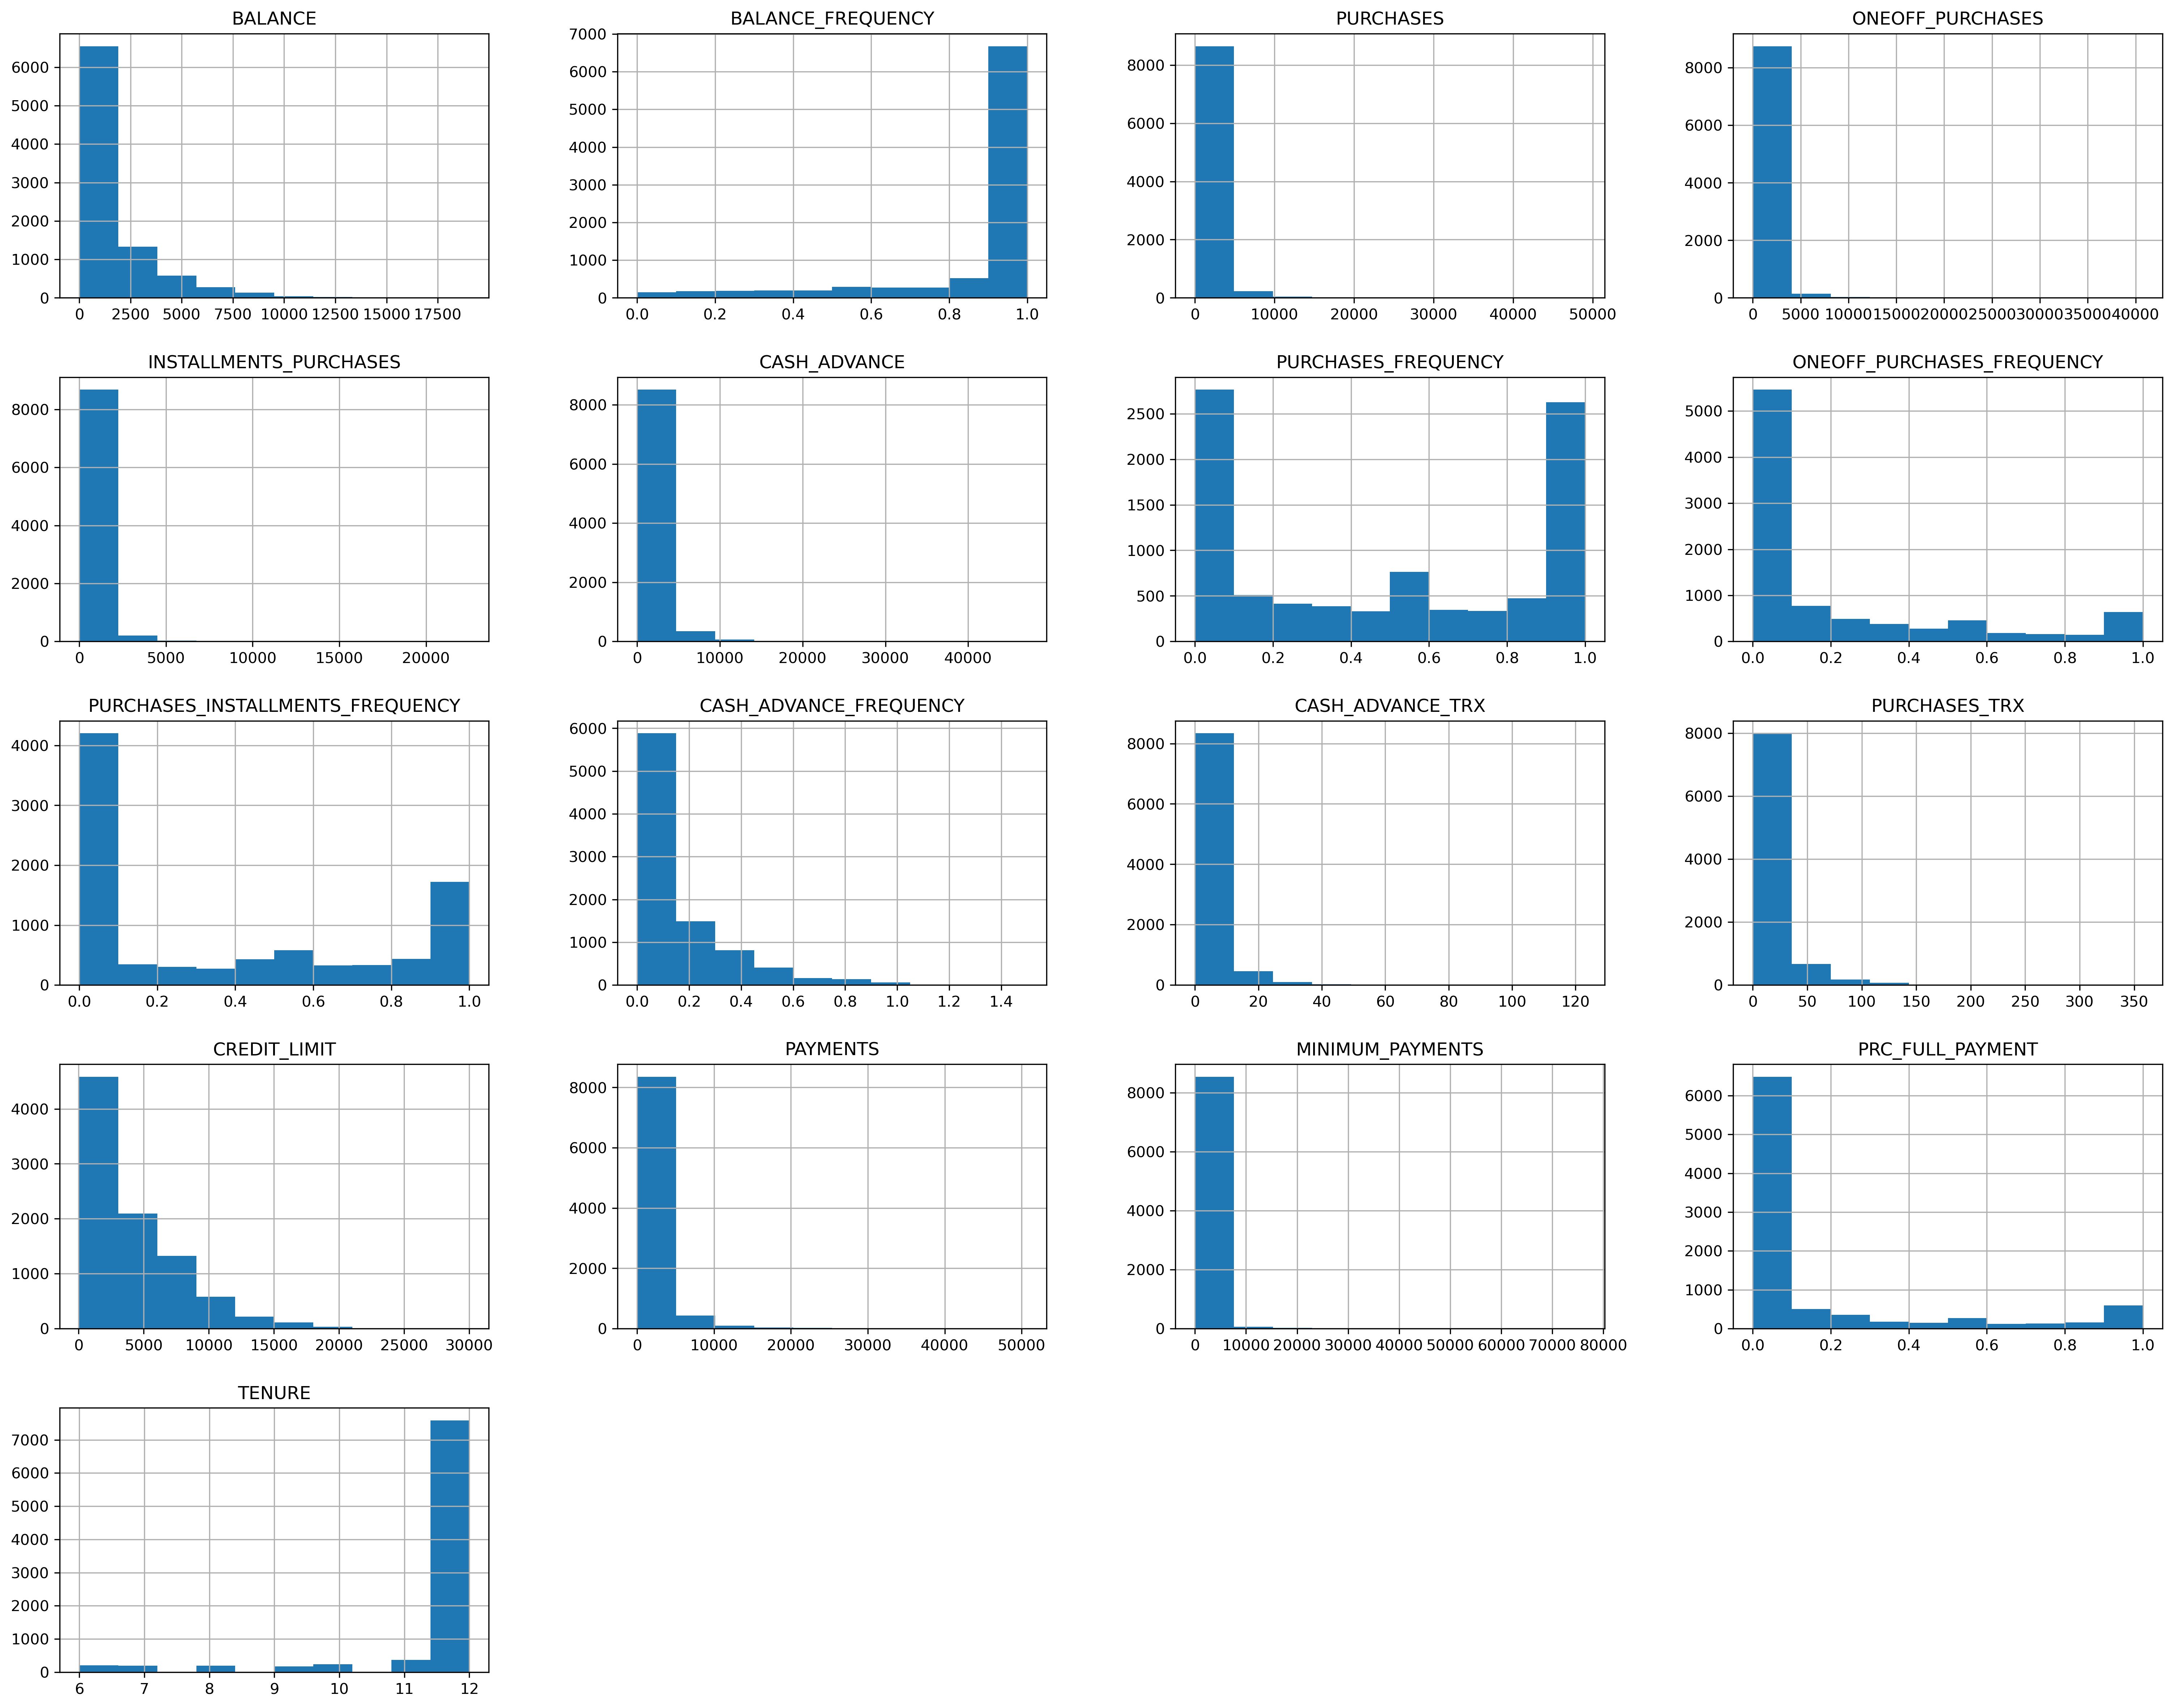

In [5]:
h=df.hist()

Some interesting multimodal distributions here that lend credence to the idea that we will have distinct clusters. Will probably want to normalize the data (between 0 and 1) rather than standardize (mean 0 std 1) since none of them have a gaussian distribution

<AxesSubplot:>

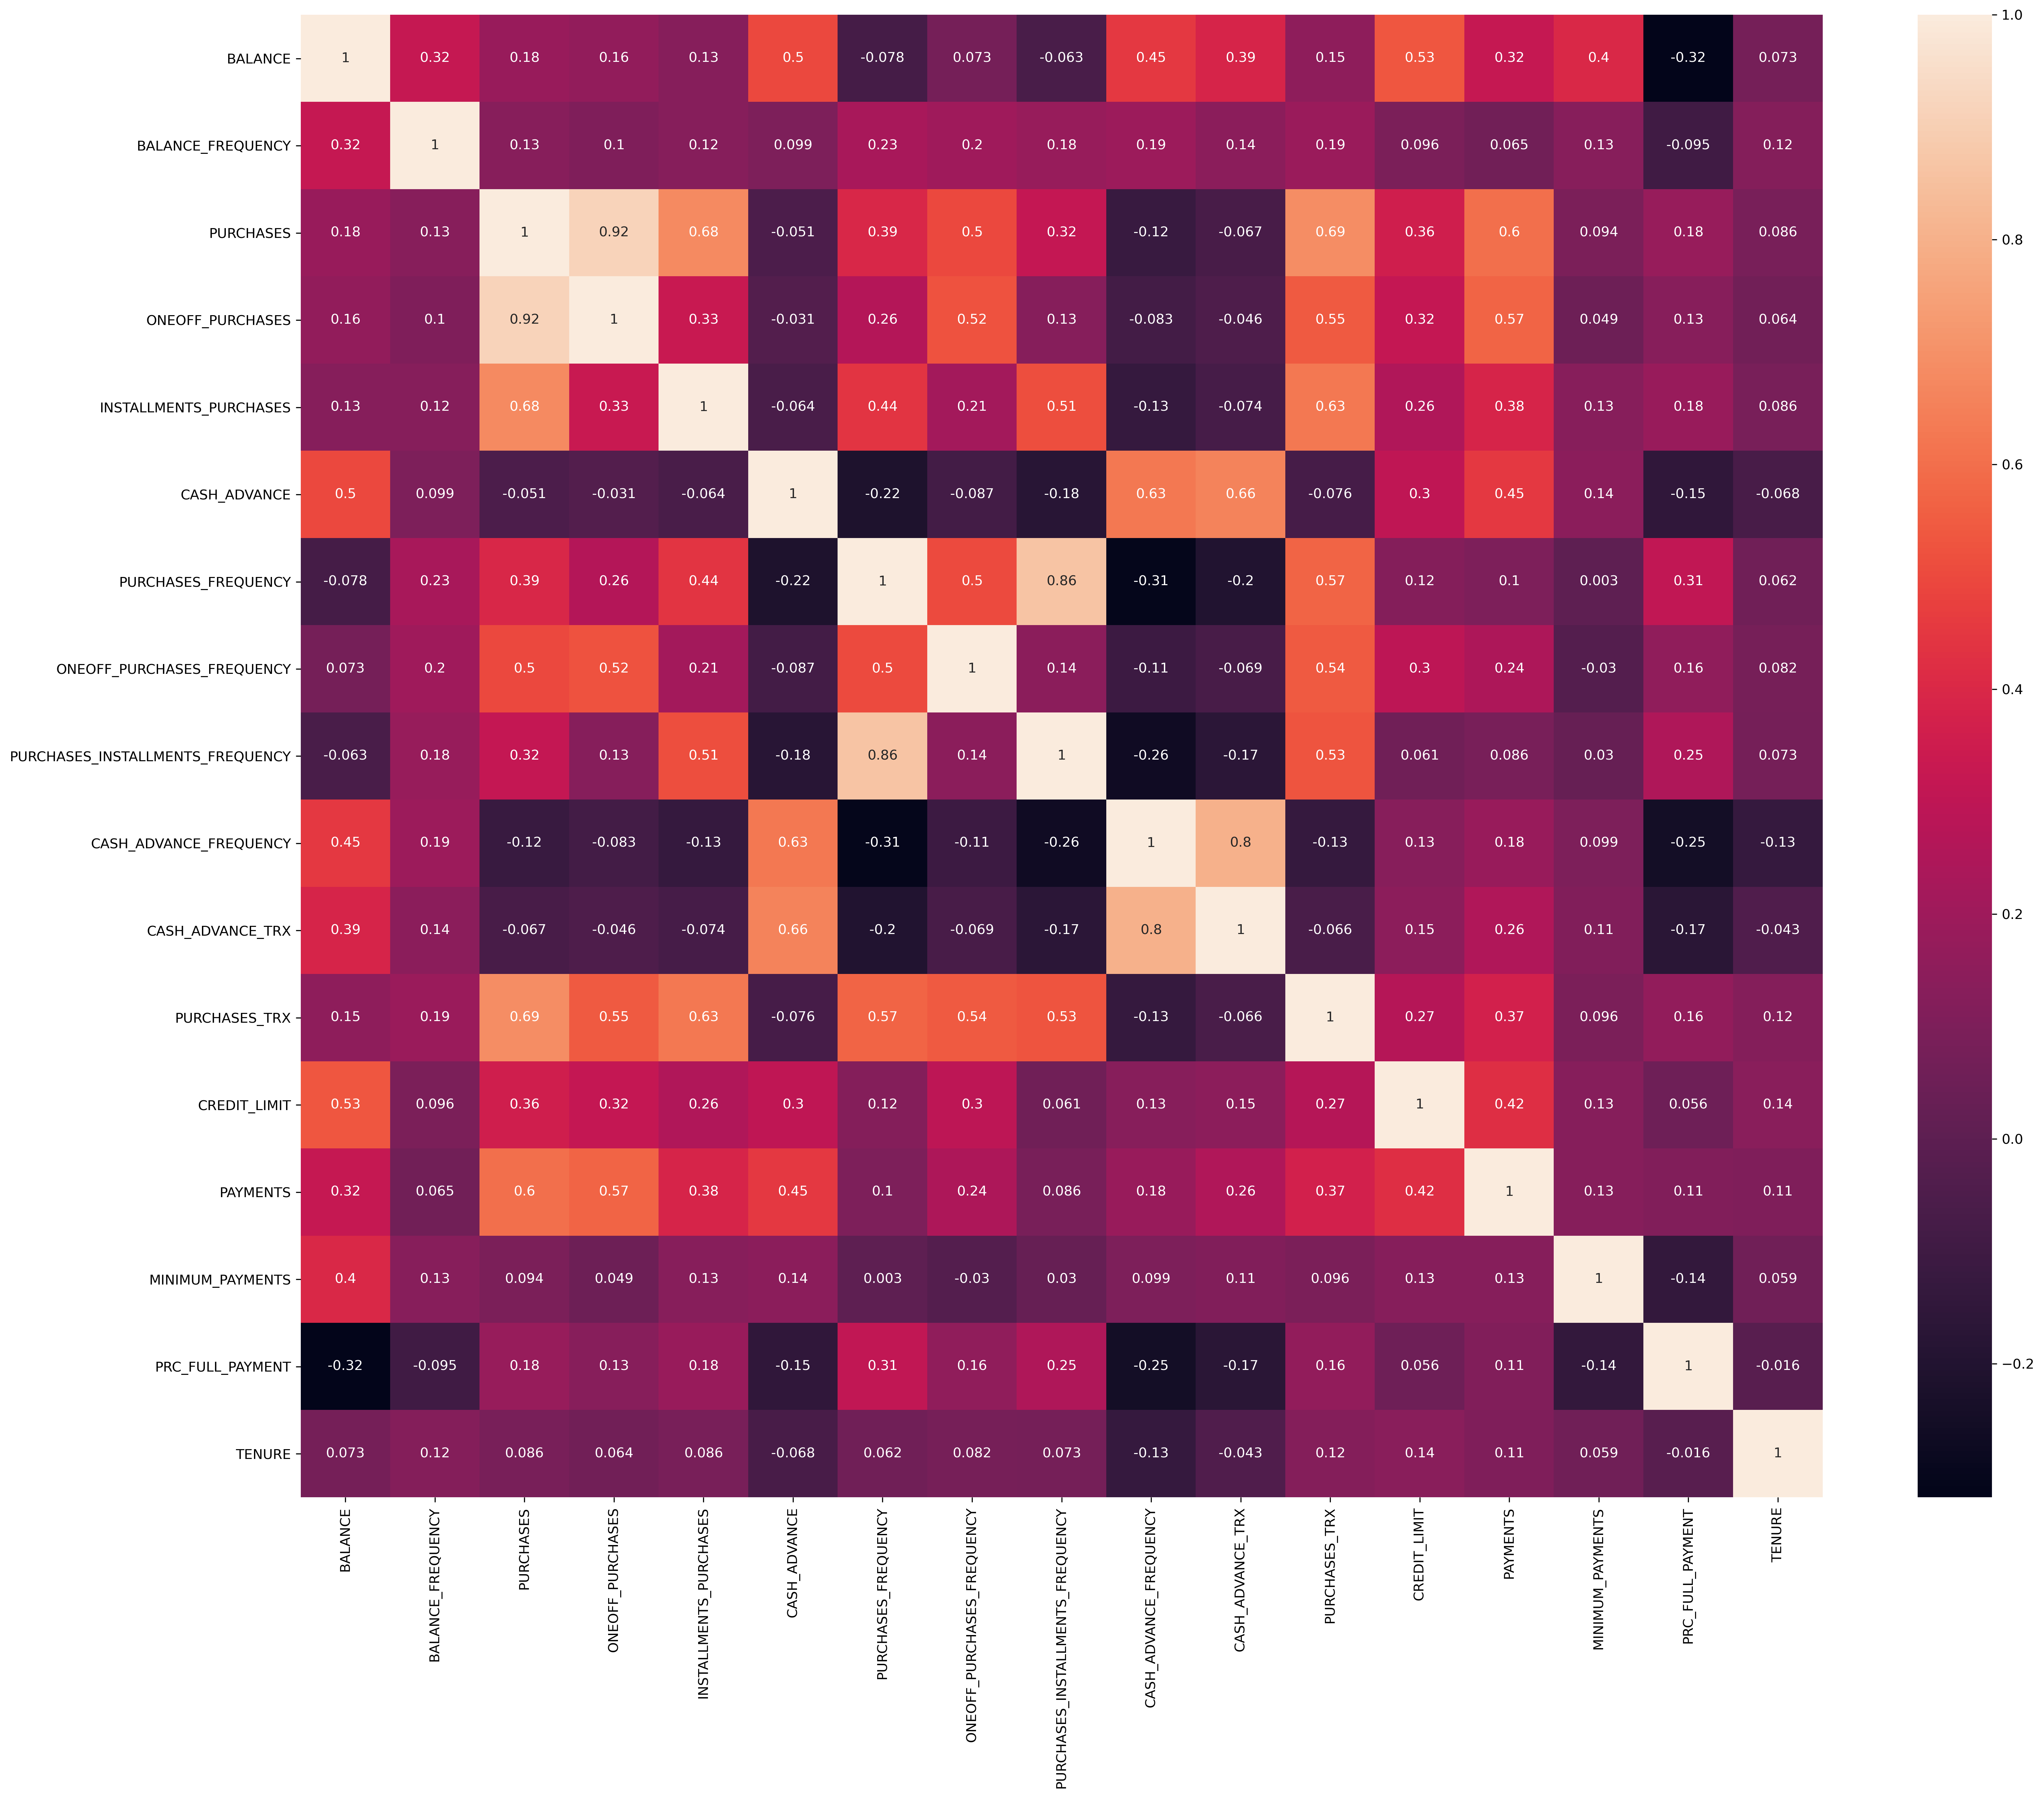

In [6]:
sns.heatmap(df.corr(),
           xticklabels=df.columns.values,
            yticklabels=df.columns.values,
           annot=True)

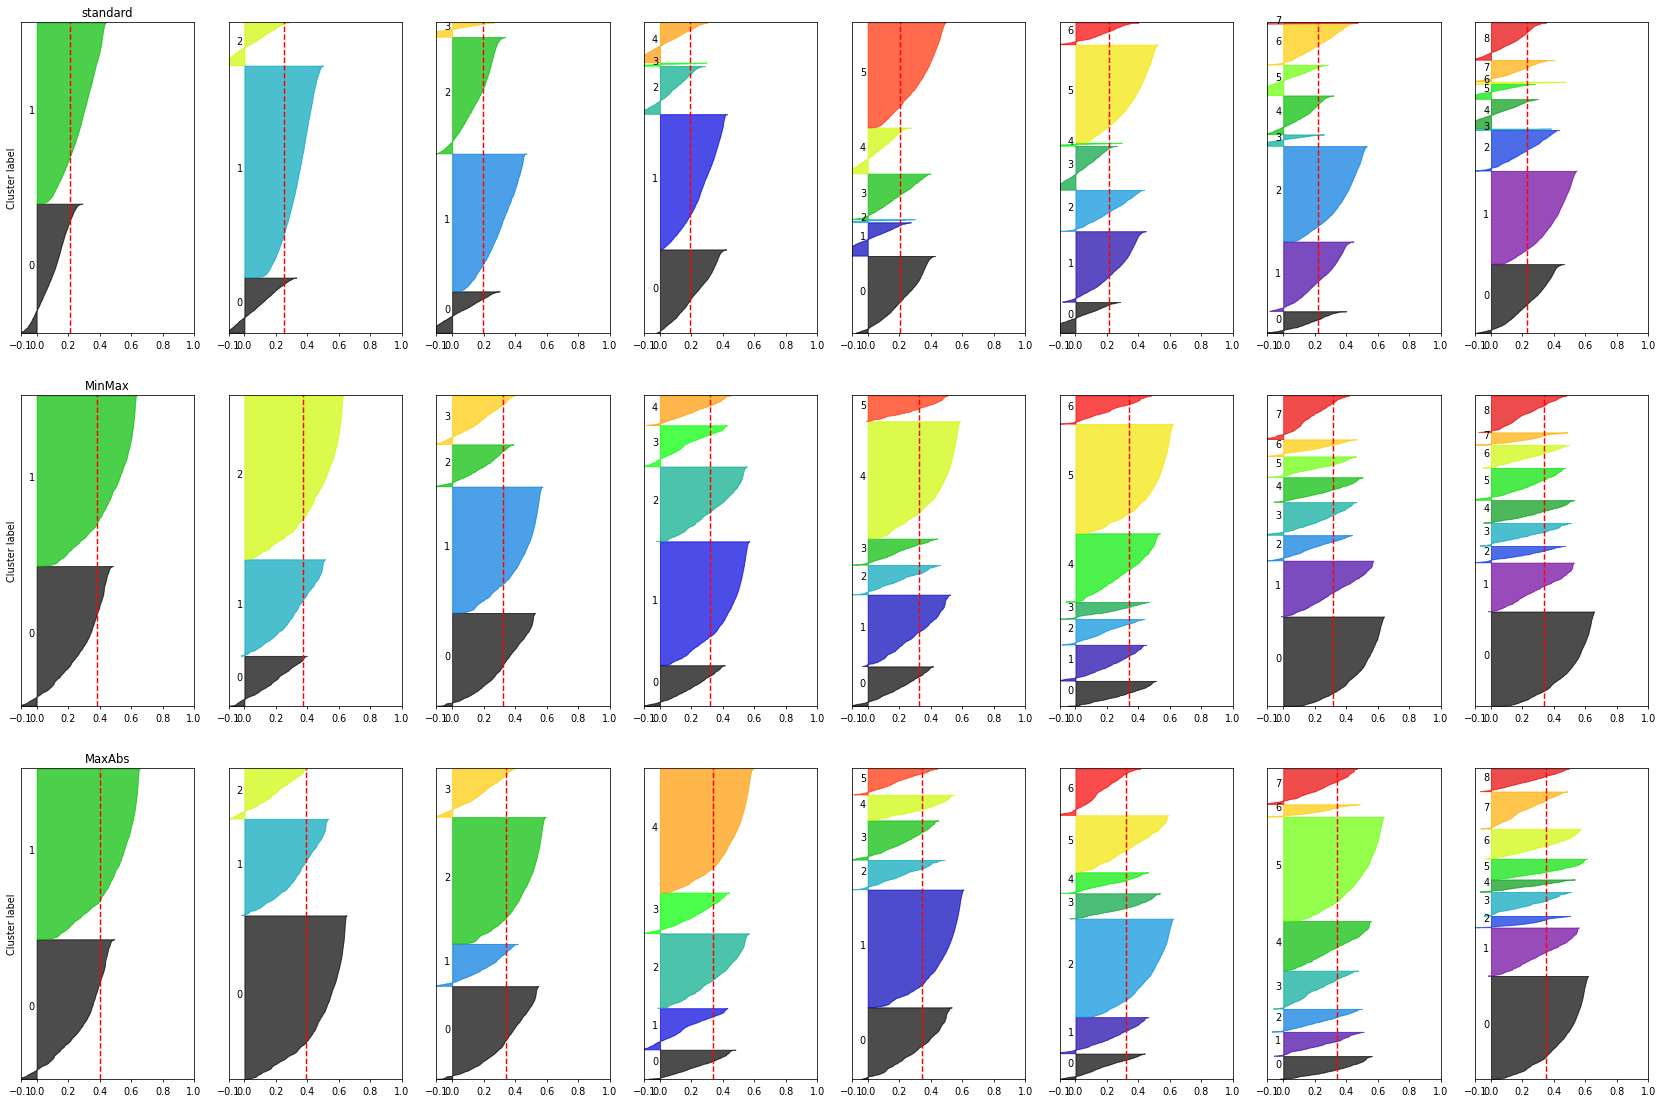

In [7]:
scalers=[StandardScaler(),MinMaxScaler(),MaxAbsScaler()]
titles = ['standard','MinMax','MaxAbs']
val=1
sse=[]
for idx,scaler in enumerate(scalers):
    
    pipe = make_pipeline(KNNImputer(),scaler)
    X = pipe.fit_transform(df)
    plt.rcParams['figure.figsize'] = [30, 20]
    plt.rcParams['figure.dpi'] = 70
    y=np.array([])
    range_n_clusters = np.arange(2,10,1)
    
    for idx_n,n_clusters in enumerate(range_n_clusters):
        km_model = KMeans(n_clusters=n_clusters).fit(X)
        cluster_labels = km_model.predict(X)
        sse.append(km_model.inertia_)

        silhouette_avg = silhouette_score(X, cluster_labels)
        #print("For n_clusters =", n_clusters,
        #      "The average silhouette_score is :", silhouette_avg)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        
        plt.subplot(len(scalers),len(range_n_clusters),val)
        val+=1
        plt.xlim([-0.1, 1])
        plt.ylim([0, len(X) + (n_clusters + 1) * 10])


        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        #plt.set_title("The silhouette plot for the various clusters.")
        #plt.xlabel("The silhouette coefficient values")
        #plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        #plt.title(("Silhouette analysis for KMeans clustering on sample data "
                      #"with n_clusters = %d"),
                     #fontsize=14, fontweight='bold')
        if idx_n == 0:
            plt.ylabel("Cluster label")
            plt.title(titles[idx])
        if idx == 3:
            plt.xlabel("The silhouette coefficient values")
                

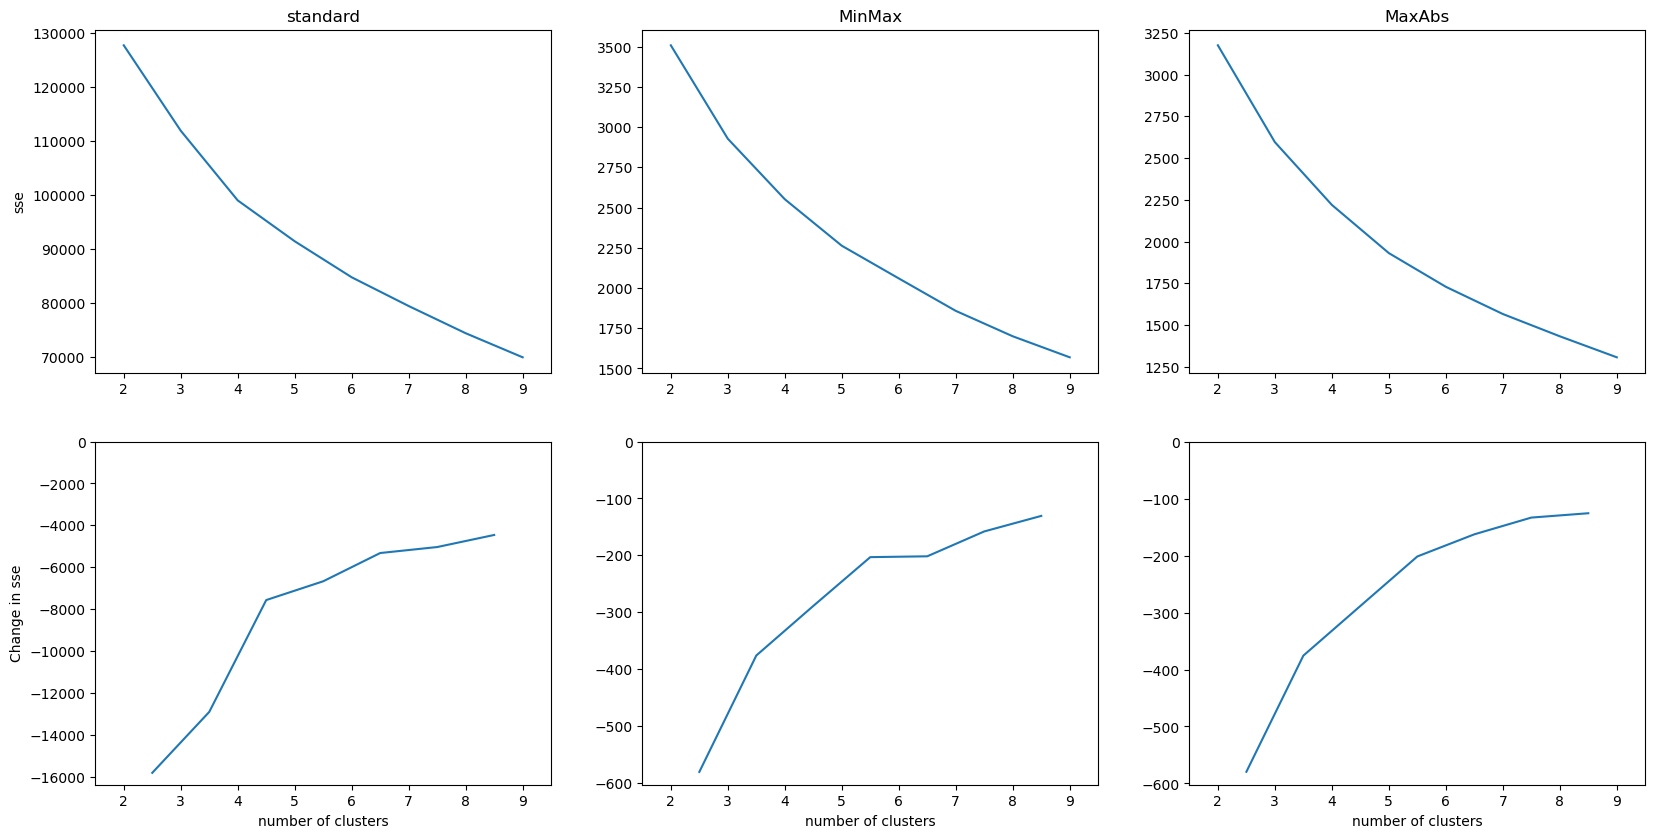

In [8]:
sse_plot =np.array(sse).reshape(3,8)
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 100
for k in range(0,3):
    plt.subplot(2,3,k+1)
    plt.plot(range_n_clusters,sse_plot[k,:])
    plt.title(titles[k])
    if k == 0:
        plt.ylabel('sse')
    plt.xlim([1.5,9.5])
    plt.subplot(2,3,k+1+3)
    plt.plot(range_n_clusters[:-1]+0.5,np.diff(sse_plot[k,:]))
    plt.xlabel('number of clusters')
    if k == 0:
        plt.ylabel('Change in sse')
    plt.xlim([1.5,9.5])
    plt.ylim(top=0)
        

The silhouette analysis is an interesting method to assess the number of clusters. The point is the calculate the silhoutte score for each point. It is a value which increases as a point is further away from other clusters with a max value of 1. For each plot, we are hoping for each grouping to be consistent in size and shape and the sharp triangle shapes are not great but unavoidable for real data. Also we would prefer the top of the fill plot to lie mostly above the average silhoutte score i.e. the red dotted line. I am using this in addition to the elbow method where we use the sum of squared distance from the mean with increasing numbers of clusters. In theory, we would have a rapid improvement in measured distances from each point to the mean as we increase from 2 clusters (or 1) and then we get to a point of diminishing returns.

So we therefore have two metrics, the first is the distance from adjacent clusters and the second is the closeness of each point to its own cluster.

The first conclusion where we are assessing different methods for data scaling, we see that in isolation, the standard scaler if we only used the elbow method would look fine with the expected curve shape. However the silhouette plots do not show a consistent change with large swathes of negative values and very small clusters randomly showing up. The MinMaxScaler and MaxAbsScaler seem to give comparably favourable silhoutte plots and even the elbow plots are similar. This is not surprising because much of the data already lies on the 0 to 1 scale and we do not see any normally distributed data where the StandardScaler would work more effectively. The MaxAbs scaler seems to be a bit better than MinMax. The silhoutte plots of the two are indistinguishable  however the improvement of about 10% is visible on the elbow plots. 

I am not a huge fan of the arbitrary selection of the "elbow", especially with how gradual the elbow curves are here. I plot the first derivative of the elbow and for the MaxAbs scaler, we see a clear plateau indicating that going to 9 clusters makes no difference. While 8 seems to be a lot of clusters, I don't think its unreasonable for this dataset type i.e. type of bank customers.

Explained variance for the first three components are:
[52.50938103 14.82401062 13.54788763]
Cumulative Explained variance for the first three components are:
[52.50938103 67.33339164 80.88127927]


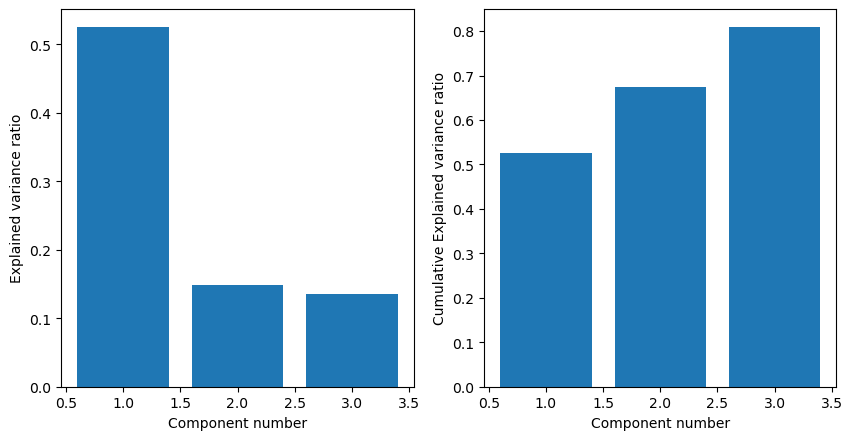

In [9]:
plt.rcParams['figure.figsize'] = [10, 5]

n_components = 3
n_clusters=8
pca = PCA(n_components=n_components)
X_r = pca.fit_transform(X) #We can just use X here because it was the final scaler tested in the pipeline earlier. Otherwise, I would write a new pipeline with all the steps included.

km_model = KMeans(n_clusters=n_clusters).fit(X)
y = km_model.predict(X)

plt.subplot(1,2,1)
plt.bar(np.arange(1,n_components+1,1),pca.explained_variance_ratio_)
plt.xlabel('Component number')
plt.ylabel('Explained variance ratio')

plt.subplot(1,2,2)
plt.bar(np.arange(1,n_components+1,1),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component number')
plt.ylabel('Cumulative Explained variance ratio')

print('Explained variance for the first three components are:')
print(pca.explained_variance_ratio_*100)
print('Cumulative Explained variance for the first three components are:')
print(np.cumsum(pca.explained_variance_ratio_*100))

Using the first three components determined by principle component analysis (PCA), we can explain 80 % of the variance observed and perfect for visualization in a 3D plot, allowing us to view our clustering efforts

Text(0.5, 0, 'PC3')

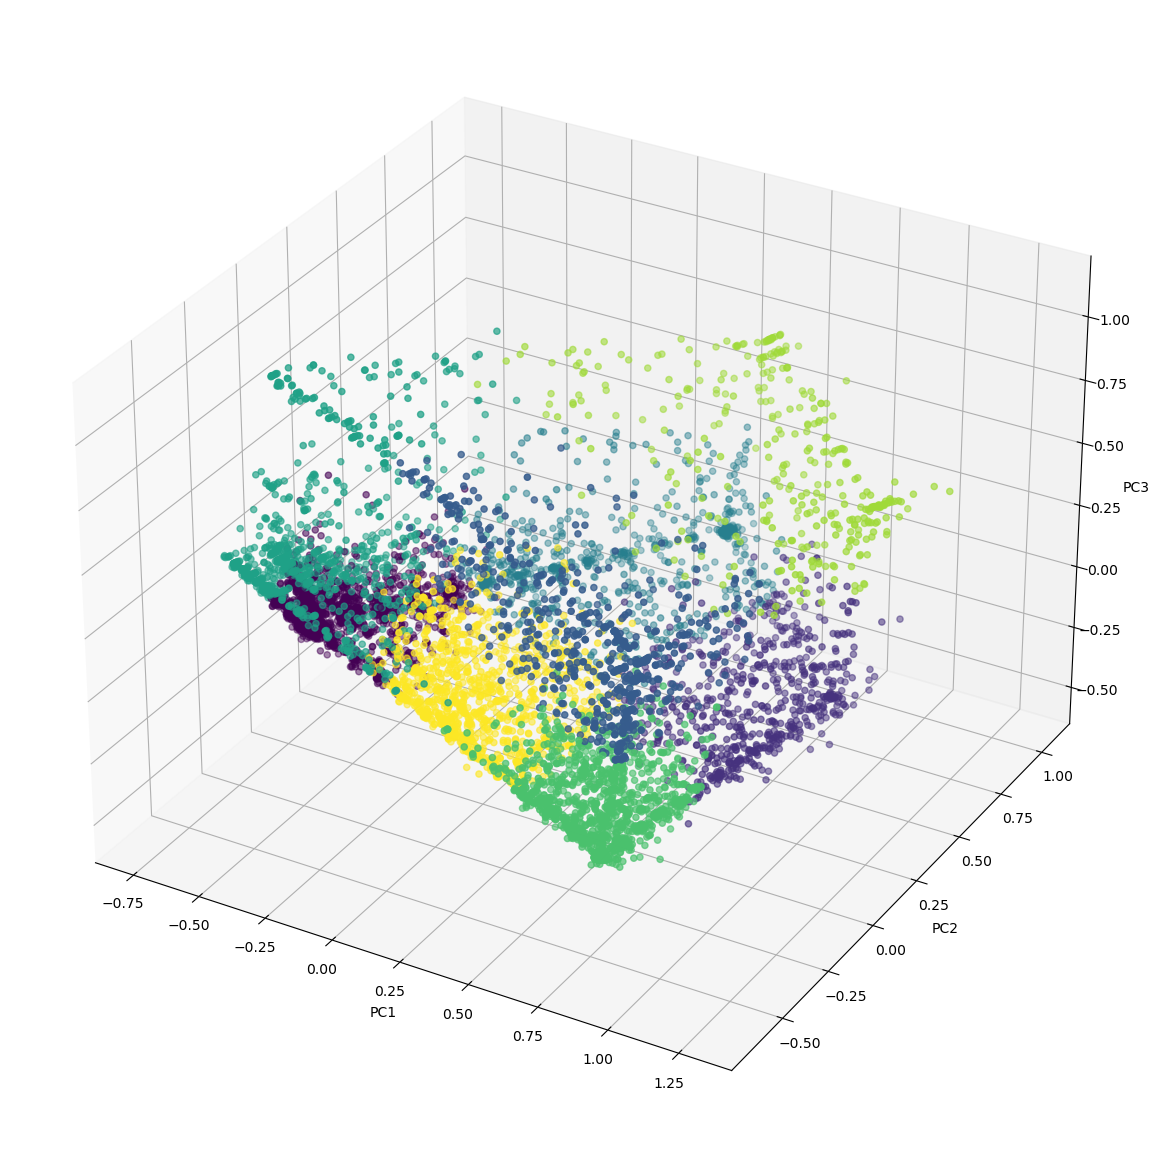

In [10]:
plt.rcParams['figure.figsize'] = [15, 15]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_r[:,0],X_r[:,1],X_r[:,2],c=y,marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [11]:
df['y_pred']=y
df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
CUST_ID                                                                
C10001     40.900749           0.818182      95.40              0.00   
C10002   3202.467416           0.909091       0.00              0.00   
C10003   2495.148862           1.000000     773.17            773.17   
C10004   1666.670542           0.636364    1499.00           1499.00   
C10005    817.714335           1.000000      16.00             16.00   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
CUST_ID                                                              
C10001                     95.4      0.000000             0.166667   
C10002                      0.0   6442.945483             0.000000   
C10003                      0.0      0.000000             1.000000   
C10004                      0.0    205.788017             0.083333   
C10005                      0.0      0.000000             0.083333   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
CUST_ID                                                                 
C10001                     0.000000                          0.083333   
C10002                     0.000000                          0.000000   
C10003                     1.000000                          0.000000   
C10004                     0.083333                          0.000000   
C10005                     0.083333                          0.000000   

         CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  \
CUST_ID                                                            
C10001                 0.000000                 0              2   
C10002                 0.250000                 4              0   
C10003                 0.000000                 0             12   
C10004                 0.083333                 1              1   
C10005                 0.000000                 0              1   

         CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  \
CUST_ID                                                                  
C10001         1000.0   201.802084        139.509787          0.000000   
C10002         7000.0  4103.032597       1072.340217          0.222222   
C10003         7500.0   622.066742        627.284787          0.000000   
C10004         7500.0     0.000000               NaN          0.000000   
C10005         1200.0   678.334763        244.791237          0.000000   

         TENURE  y_pred  
CUST_ID                  
C10001       12       0  
C10002       12       0  
C10003       12       3  
C10004       12       0  
C10005       12       0

In [12]:
df.groupby('y_pred').mean()

BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
y_pred                                                                  
0       2236.586351           0.967392   184.537891        169.235204   
1       3019.090581           0.988711  3839.286070       2465.924249   
2        108.149837           0.896815  1003.276722        144.736798   
3       1805.173104           0.965554  1533.400853       1436.009870   
4        162.103427           0.346025   313.282529        249.119591   
5       1402.436728           0.923748  1054.939721        236.850901   
6        404.496147           0.961545  4280.679324       3230.239803   
7       1468.155149           0.904446   738.830981        303.792634   

        INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
y_pred                                                              
0                    15.390275   1718.409513             0.072404   
1                  1373.361821    995.643154             0.968063   
2                   859.625997     41.458080             0.862626   
3                    97.802760    702.983930             0.727032   
4                    64.230545    577.666973             0.152048   
5                   818.441830    663.911585             0.953360   
6                  1050.439521    113.845267             0.927008   
7                   435.804096    739.840366             0.551483   

        ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
y_pred                                                                 
0                         0.057155                          0.014963   
1                         0.742951                          0.845572   
2                         0.056511                          0.804543   
3                         0.697111                          0.093000   
4                         0.074822                          0.073780   
5                         0.083581                          0.916479   
6                         0.867678                          0.504811   
7                         0.113791                          0.449467   

        CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
y_pred                                                                          
0                     0.243408          5.762330       1.425687   4170.215562   
1                     0.128183          3.538695      58.054628   7565.326252   
2                     0.005886          0.131420      17.287009   3815.335759   
3                     0.116081          2.566474      18.901734   4980.346821   
4                     0.056521          1.247082       2.535992   3883.287894   
5                     0.087462          2.066341      23.044693   3731.913408   
6                     0.024104          0.622535      48.225352   7541.682458   
7                     0.103179          2.735695      10.751135   4228.311269   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT     TENURE  
y_pred                                                              
0       1495.801799       1058.688091          0.021809  11.468057  
1       3831.490655       1185.741004          0.065301  11.827011  
2       1134.824189        192.760509          0.804984  11.220544  
3       1751.252579        720.605568          0.072522  11.527457  
4       1460.188995        180.185172          0.202403  11.305447  
5       1448.041772       1258.026263          0.062759  11.548184  
6       4170.192883        241.989780          0.871751  11.802817  
7       1316.674772        878.957648          0.069328  11.704814

In [13]:
df.groupby('y_pred').median()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
y_pred                                                                
0       1521.168100           1.000000      0.000              0.00   
1       2134.176153           1.000000   2821.760           1653.16   
2         59.708529           1.000000    620.400              0.00   
3       1186.602298           1.000000   1024.515            947.73   
4         31.838169           0.363636     95.000              0.00   
5        794.862976           1.000000    637.235              0.00   
6        238.962984           1.000000   2634.700           1990.05   
7        820.163313           1.000000    461.320             50.00   

        INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
y_pred                                                              
0                        0.000    853.585813             0.000000   
1                      923.380      0.000000             1.000000   
2                      564.600      0.000000             0.958333   
3                        0.000      0.000000             0.750000   
4                        0.000      0.000000             0.083333   
5                      534.725      0.000000             1.000000   
6                      452.350      0.000000             1.000000   
7                      274.780      0.000000             0.571429   

        ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
y_pred                                                                 
0                         0.000000                          0.000000   
1                         0.750000                          0.916667   
2                         0.000000                          0.833333   
3                         0.666667                          0.000000   
4                         0.000000                          0.000000   
5                         0.000000                          1.000000   
6                         0.916667                          0.500000   
7                         0.083333                          0.416667   

        CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
y_pred                                                                          
0                     0.166667                 3              0        3000.0   
1                     0.000000                 0             45        7000.0   
2                     0.000000                 0             12        3000.0   
3                     0.000000                 0             14        4000.0   
4                     0.000000                 0              1        3000.0   
5                     0.000000                 0             16        2500.0   
6                     0.000000                 0             34        7000.0   
7                     0.000000                 0              8        3000.0   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
y_pred                                                           
0        729.355023        507.351854          0.000000      12  
1       2370.147958        616.959061          0.000000      12  
2        687.966236        160.210691          0.833333      12  
3       1129.938963        398.520851          0.000000      12  
4        404.203943        119.317375          0.000000      12  
5        830.919637        341.834852          0.000000      12  
6       2597.718416        180.637896          0.916667      12  
7        709.240603        330.828719          0.000000      12

In [14]:
df.groupby('y_pred')['BALANCE'].count()

y_pred
0    3021
1     659
2     662
3     692
4    1028
5    1432
6     355
7    1101
Name: BALANCE, dtype: int64

In [15]:
df_freq=df[["BALANCE_FREQUENCY","PURCHASES_FREQUENCY","ONEOFF_PURCHASES_FREQUENCY","PURCHASES_INSTALLMENTS_FREQUENCY",
                  "CASH_ADVANCE_FREQUENCY","PRC_FULL_PAYMENT","y_pred"]]
df_non_freq = df.drop(columns=["BALANCE_FREQUENCY","PURCHASES_FREQUENCY","ONEOFF_PURCHASES_FREQUENCY","PURCHASES_INSTALLMENTS_FREQUENCY",
                  "CASH_ADVANCE_FREQUENCY","PRC_FULL_PAYMENT"])

df_non_freq



BALANCE  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
CUST_ID                                                                     
C10001     40.900749      95.40              0.00                   95.40   
C10002   3202.467416       0.00              0.00                    0.00   
C10003   2495.148862     773.17            773.17                    0.00   
C10004   1666.670542    1499.00           1499.00                    0.00   
C10005    817.714335      16.00             16.00                    0.00   
...              ...        ...               ...                     ...   
C19186     28.493517     291.12              0.00                  291.12   
C19187     19.183215     300.00              0.00                  300.00   
C19188     23.398673     144.40              0.00                  144.40   
C19189     13.457564       0.00              0.00                    0.00   
C19190    372.708075    1093.25           1093.25                    0.00   

         CASH_ADVANCE  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
CUST_ID                                                                
C10001       0.000000                 0              2        1000.0   
C10002    6442.945483                 4              0        7000.0   
C10003       0.000000                 0             12        7500.0   
C10004     205.788017                 1              1        7500.0   
C10005       0.000000                 0              1        1200.0   
...               ...               ...            ...           ...   
C19186       0.000000                 0              6        1000.0   
C19187       0.000000                 0              6        1000.0   
C19188       0.000000                 0              5        1000.0   
C19189      36.558778                 2              0         500.0   
C19190     127.040008                 2             23        1200.0   

            PAYMENTS  MINIMUM_PAYMENTS  TENURE  y_pred  
CUST_ID                                                 
C10001    201.802084        139.509787      12       0  
C10002   4103.032597       1072.340217      12       0  
C10003    622.066742        627.284787      12       3  
C10004      0.000000               NaN      12       0  
C10005    678.334763        244.791237      12       0  
...              ...               ...     ...     ...  
C19186    325.594462         48.886365       6       2  
C19187    275.861322               NaN       6       5  
C19188     81.270775         82.418369       6       5  
C19189     52.549959         55.755628       6       0  
C19190     63.165404         88.288956       6       3  

[8950 rows x 12 columns]

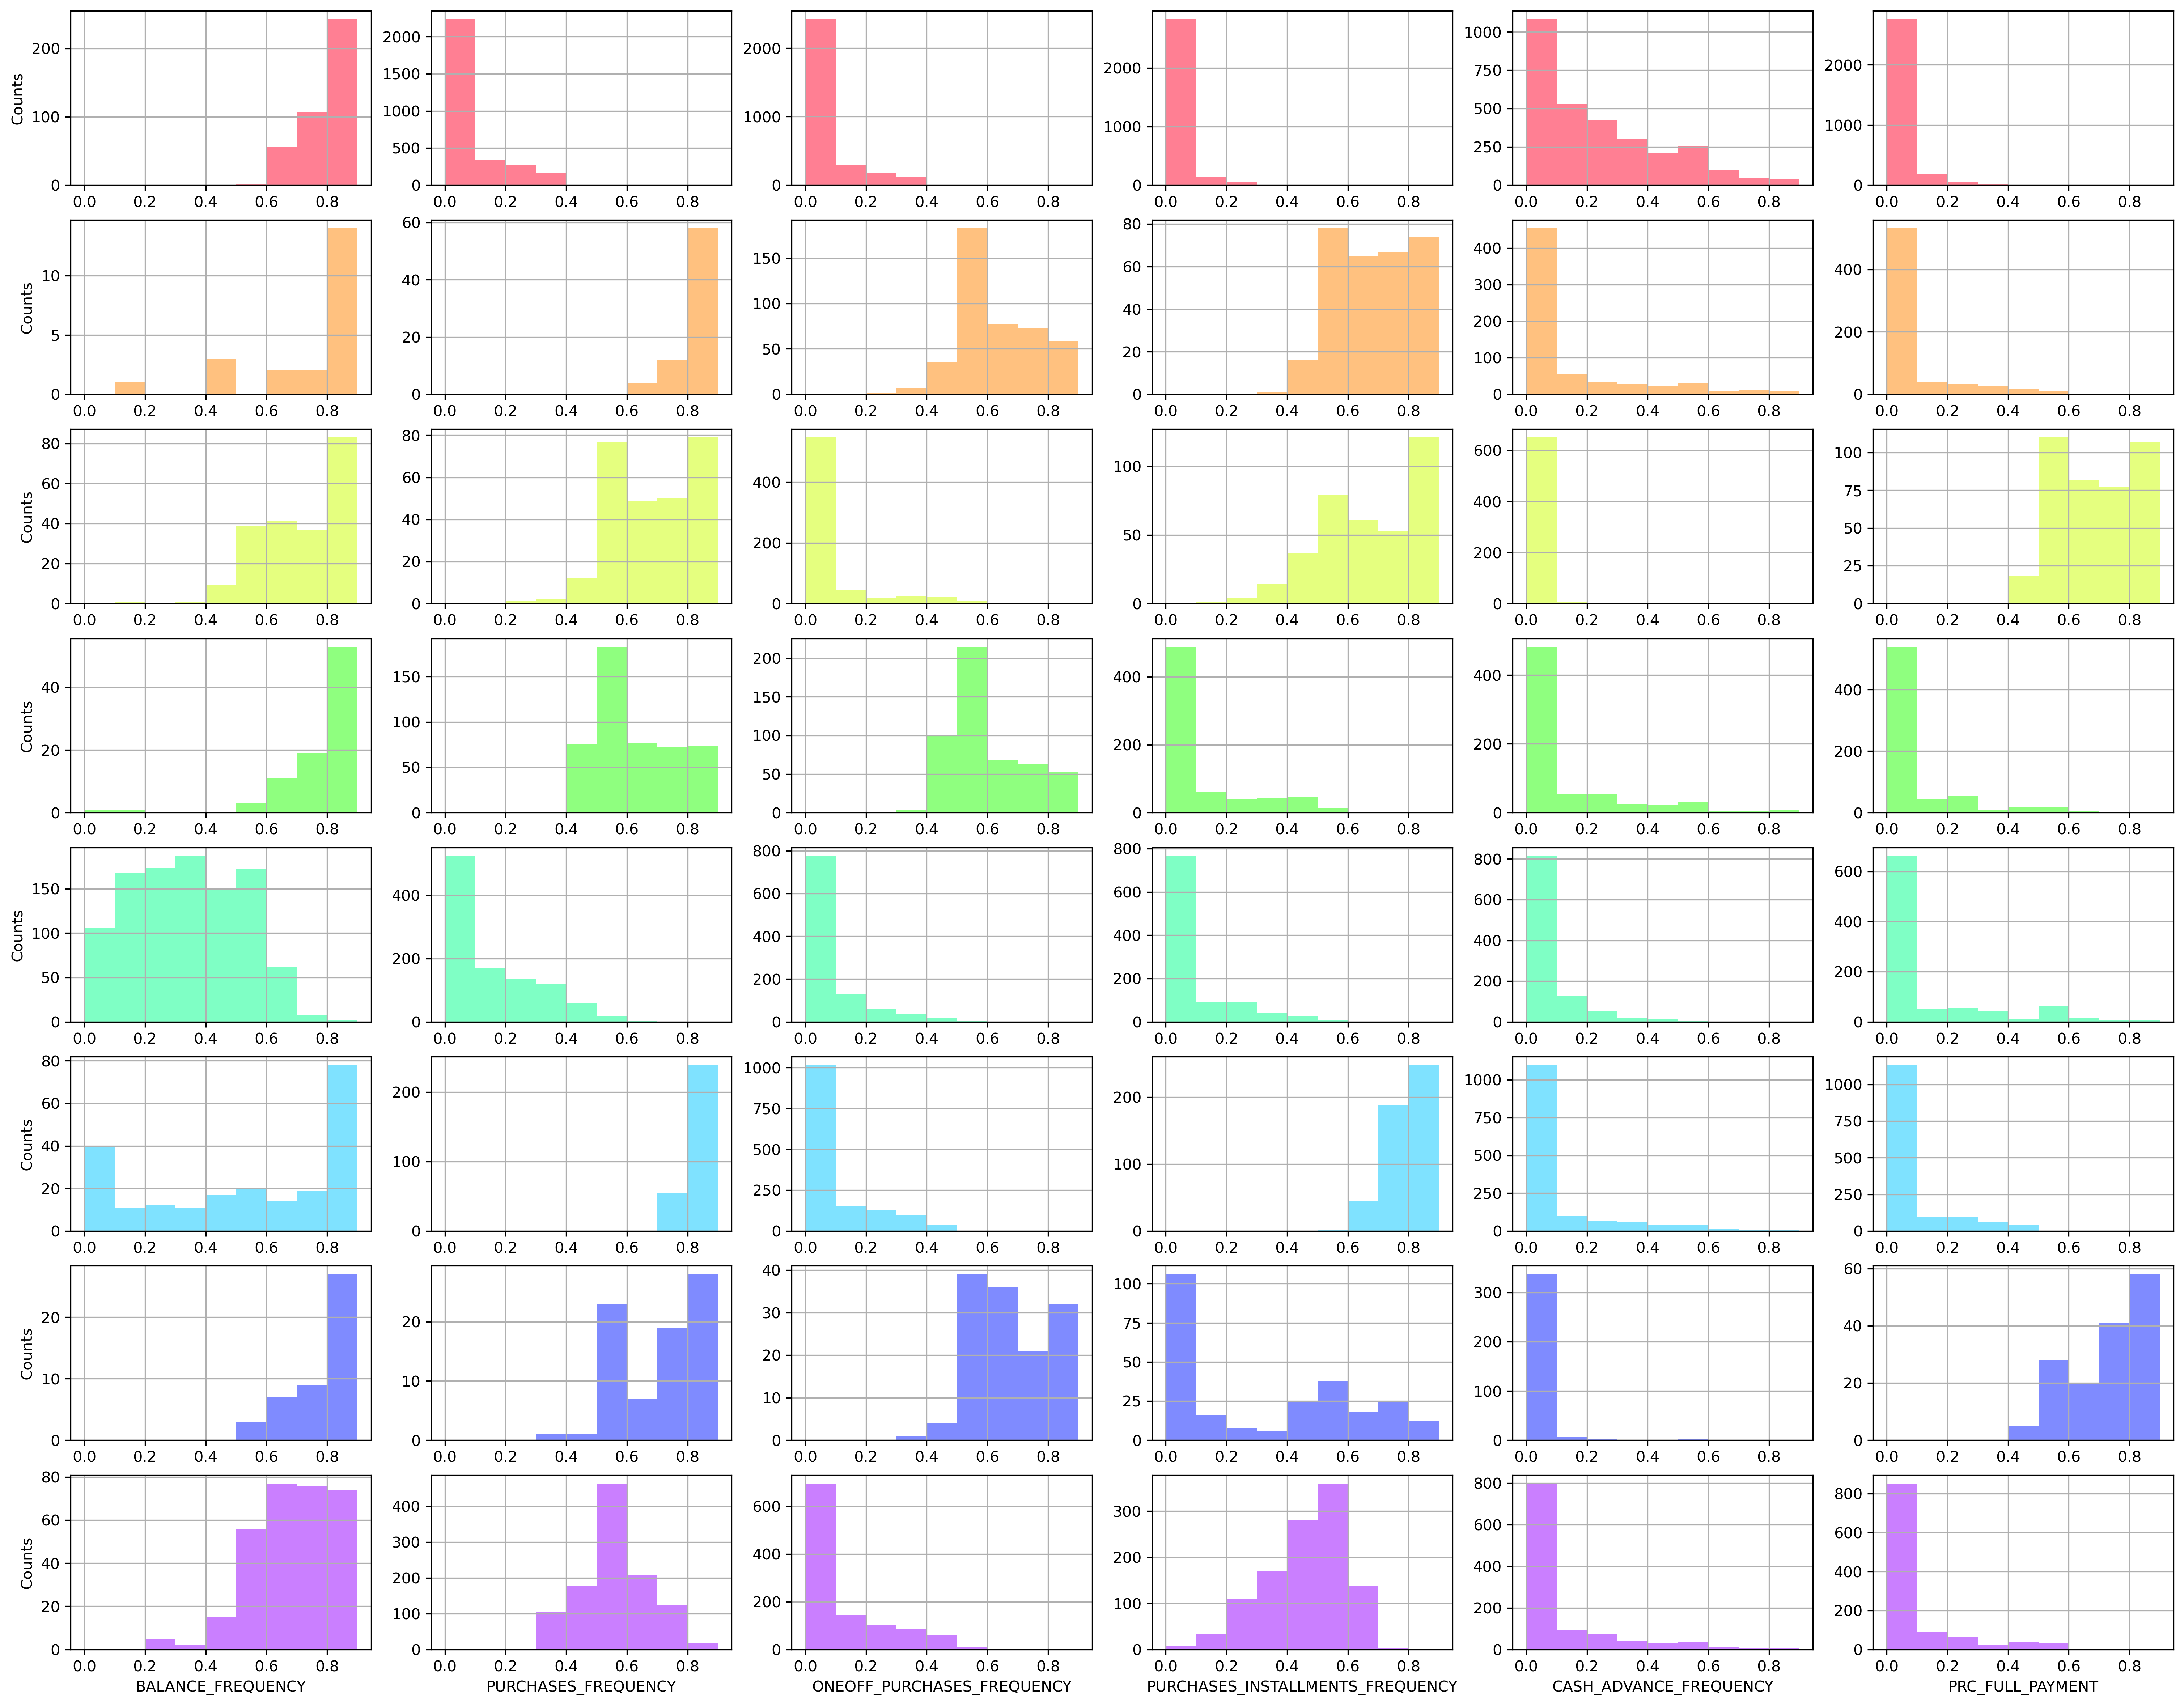

In [16]:
import pylab
plt.rcParams['figure.figsize'] = [25, 20]
plt.rcParams['figure.dpi'] = 300
NUM_COLORS = 8
iter=0
colm = pylab.get_cmap('gist_rainbow')
for k in np.arange(0,8,1):
    for j,col in enumerate(df_freq.drop(columns=['y_pred']).columns):
        color = colm(1.*k/NUM_COLORS)
        iter+=1
        plt.subplot(8,6,iter)
        df[col].loc[df['y_pred']==k].hist(color=color,bins=np.arange(0,1,0.1),alpha=0.5)
        if j == 0:
            plt.ylabel('Counts')
        if k == 7:
            plt.xlabel(col)
        

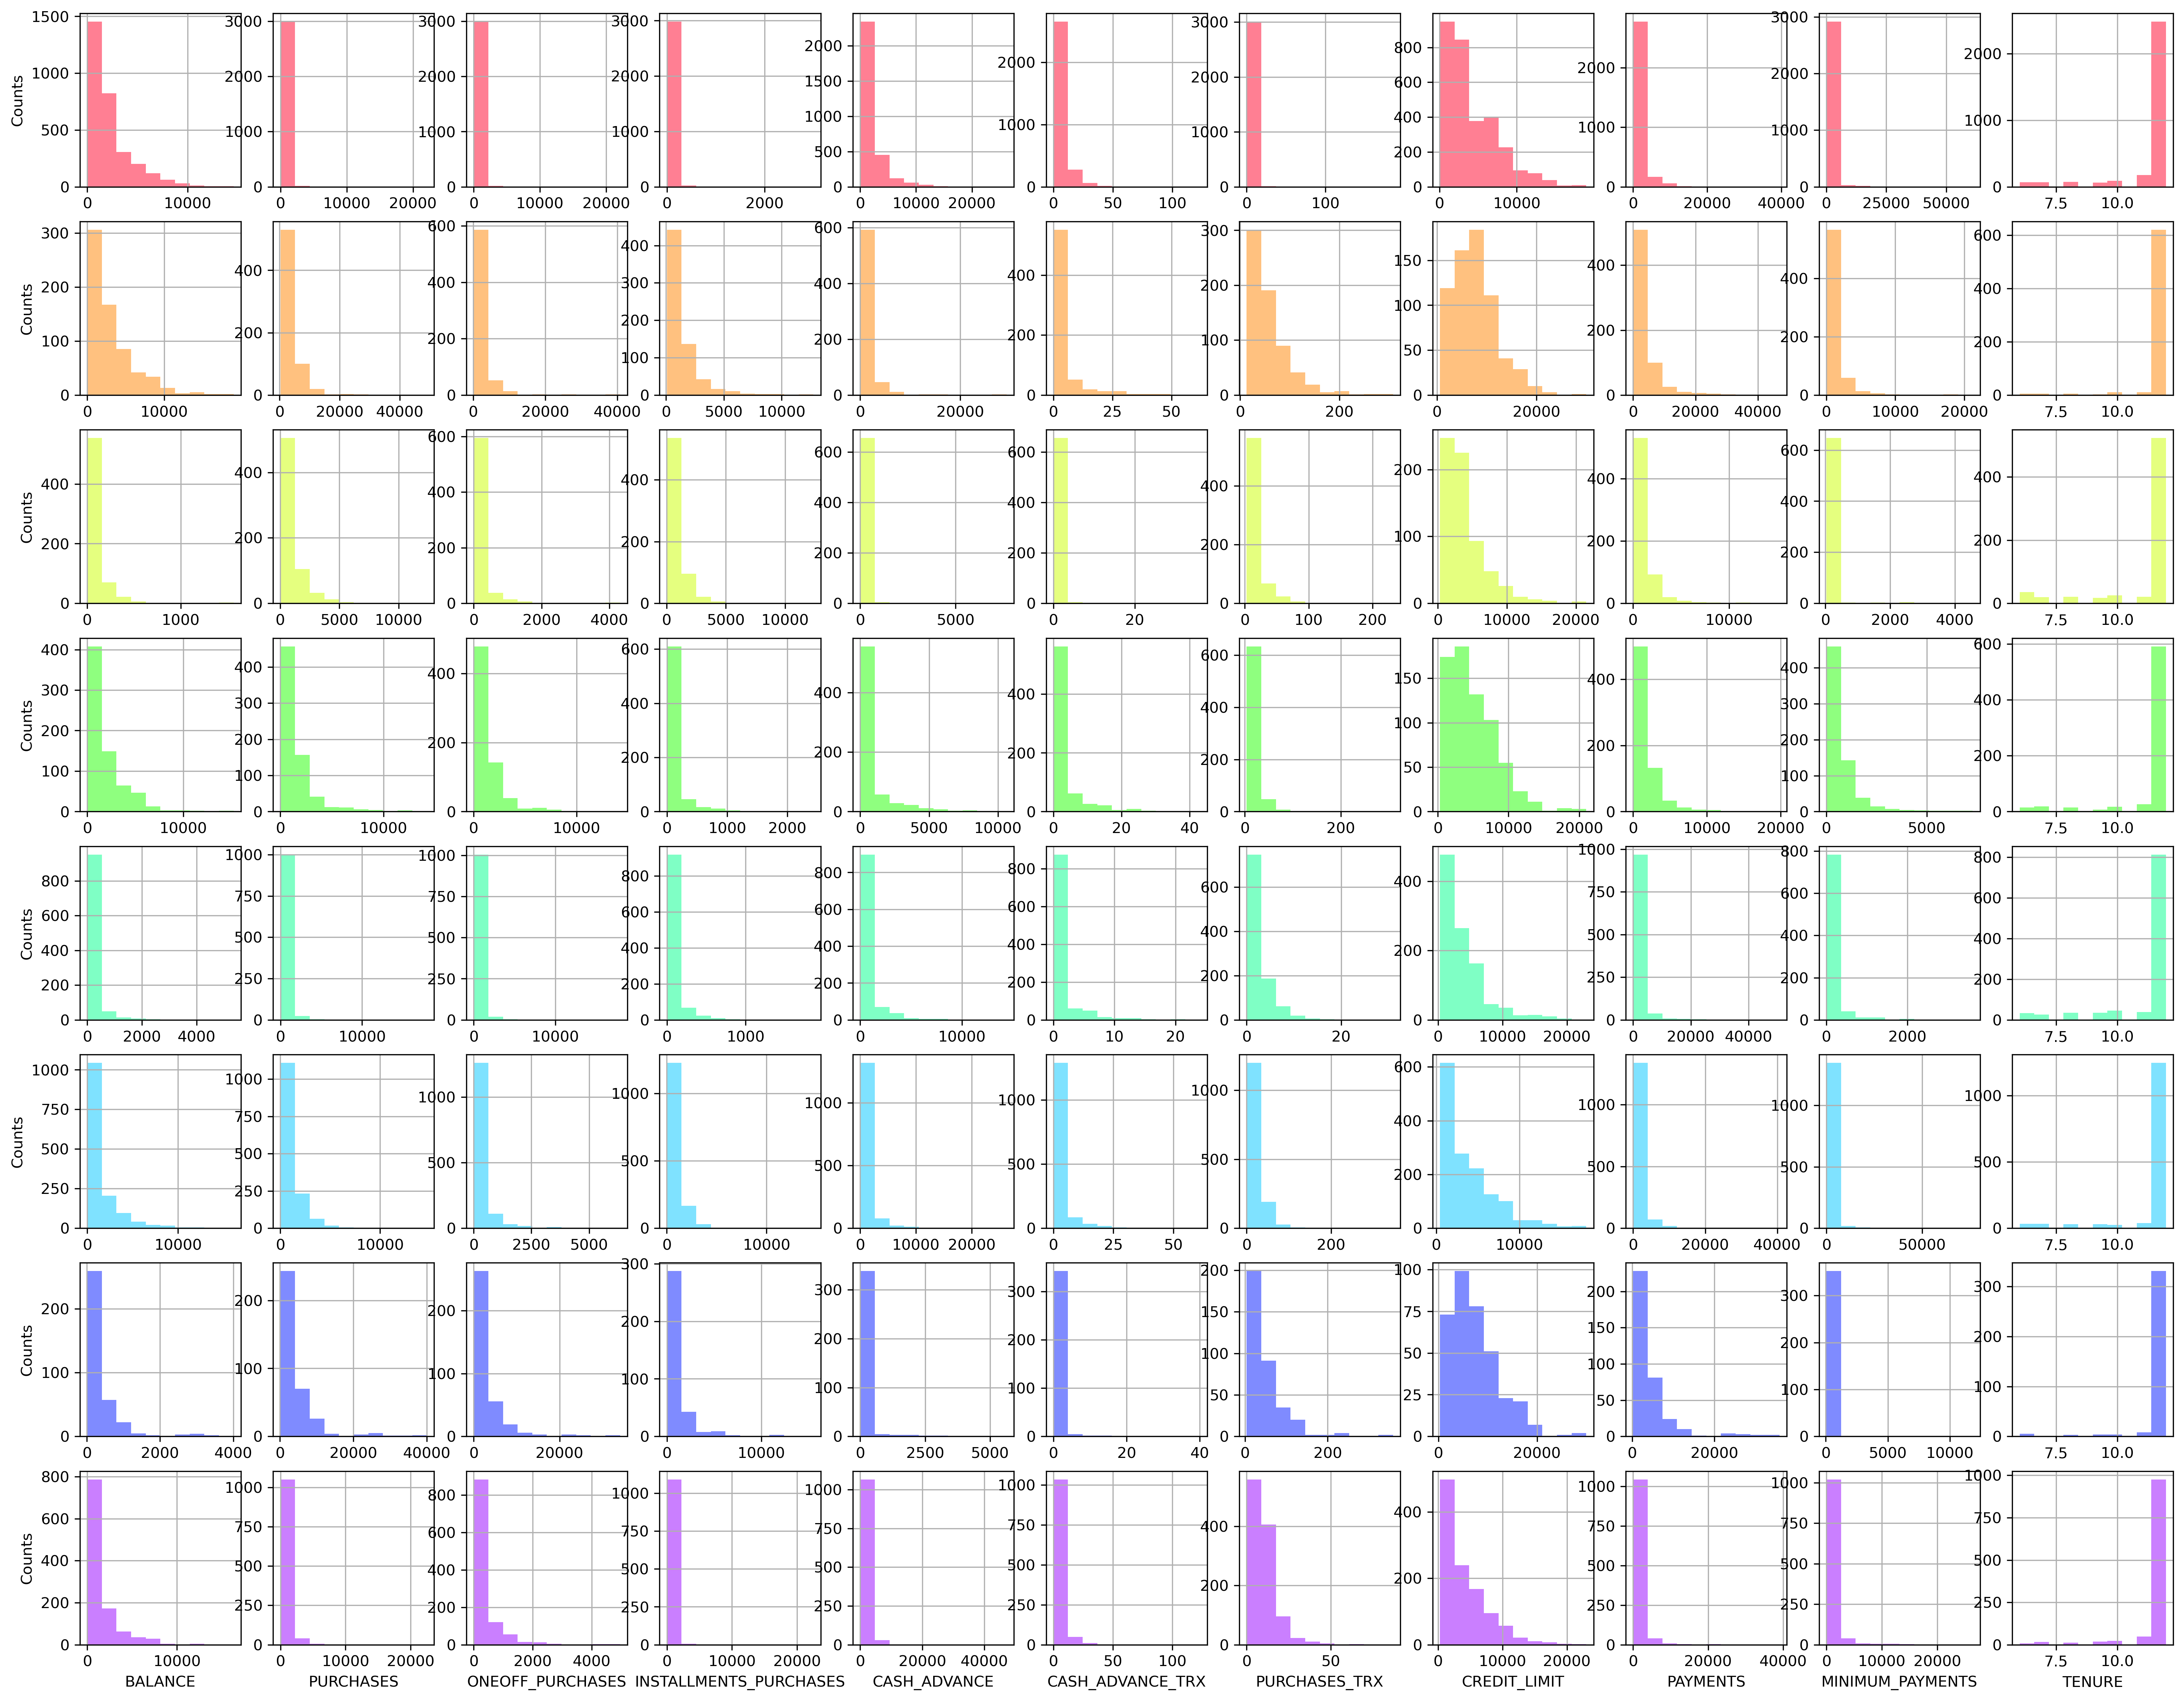

In [17]:
NUM_COLORS = 8
iter=0
colm = pylab.get_cmap('gist_rainbow')
for k in np.arange(0,8,1):
    for j,col in enumerate(df_non_freq.drop(columns=['y_pred']).columns):
        color = colm(1.*k/NUM_COLORS)
        iter+=1
        plt.subplot(8,11,iter)
        df[col].loc[df['y_pred']==k].hist(color=color,alpha=0.5)
        if j == 0:
            plt.ylabel('Counts')
        if k == 7:
            plt.xlabel(col)

The result here is not very good. While the features which lie between 0 and 1 like the frequency, All of these other features are all pretty much the same. While thinking of this, I learned about the Pareto probability distribution and perhaps in our case, doing a log transformation of these columns may help substantially. Lets try this out.

C:\Users\nicho\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\nicho\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'counts')

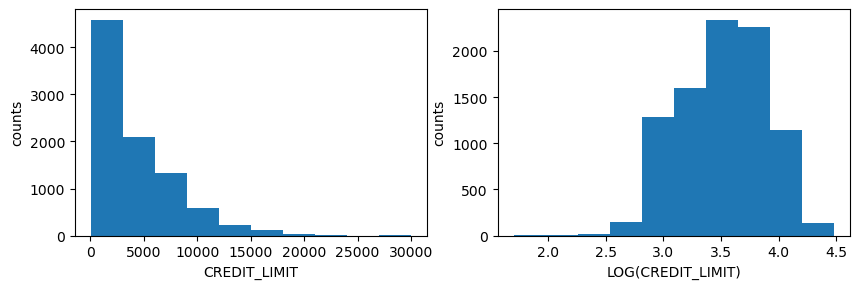

In [18]:
plt.rcParams['figure.figsize'] = [10, 3]
plt.rcParams['figure.dpi']=100
plt.subplot(1,2,1)
plt.hist(df['CREDIT_LIMIT'])
plt.xlabel('CREDIT_LIMIT')
plt.ylabel('counts')

plt.subplot(1,2,2)
plt.hist(np.log10(df['CREDIT_LIMIT']))
plt.xlabel('LOG(CREDIT_LIMIT)')
plt.ylabel('counts')

# This log transformation will make a really big difference since the data will scale much much better

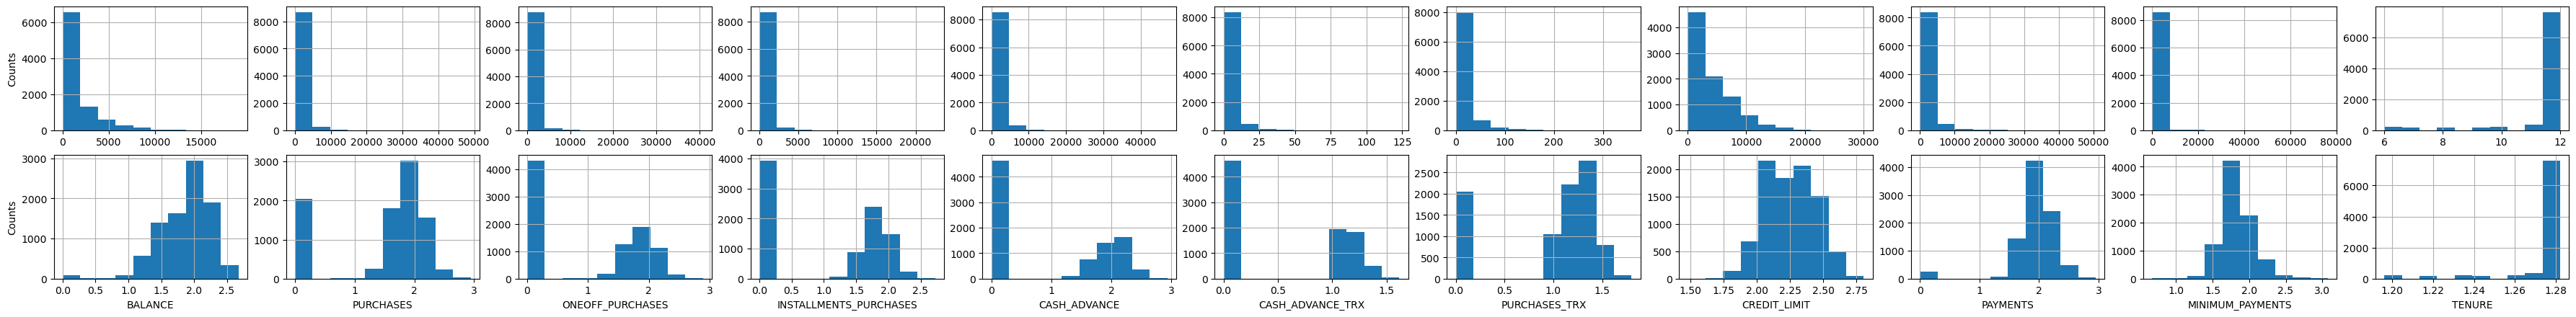

In [19]:
plt.rcParams['figure.figsize'] = [45, 5]
plt.rcParams['figure.dpi']=100

iter=0
#for k in np.arange(0,1,1):
for j,col in enumerate(df_non_freq.drop(columns=['y_pred']).columns):
    #color = cm(1.*k/NUM_COLORS)
    iter+=1
    plt.subplot(2,11,iter)
    df_non_freq[col].hist()
    if j == 0:
        plt.ylabel('Counts')
               
for j,col in enumerate(df_non_freq.drop(columns=['y_pred']).columns):
    #color = cm(1.*k/NUM_COLORS)
    iter+=1
    plt.subplot(2,11,iter)
    (df_non_freq[col]**0.1).hist()
    if j == 0:
        plt.ylabel('Counts')
    plt.xlabel(col)

My hunch was correct, In all of these cases, doing the log transform rescales the data much more effectively. The main issue though is the fact that many of these columns have lots of 0 values of which the logarithm is undefined. I am glad I plotted out all of these graphs because the test case I used earlier happened to be the one of two of these columns without a zero value. I had to add an arbitrary small number to the values to even make the plot (you can easily see it in the graphs, especially cash advance graph). A bit more reading and help from StackExchange (https://datascience.stackexchange.com/questions/18933/convert-exponential-to-normal-distribution) I think what i want is to use the QuantileTransformer.

C:\Users\nicho\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\nicho\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\nicho\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\nicho\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\nicho\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\nicho\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\nicho\anaconda3\lib\site-pac

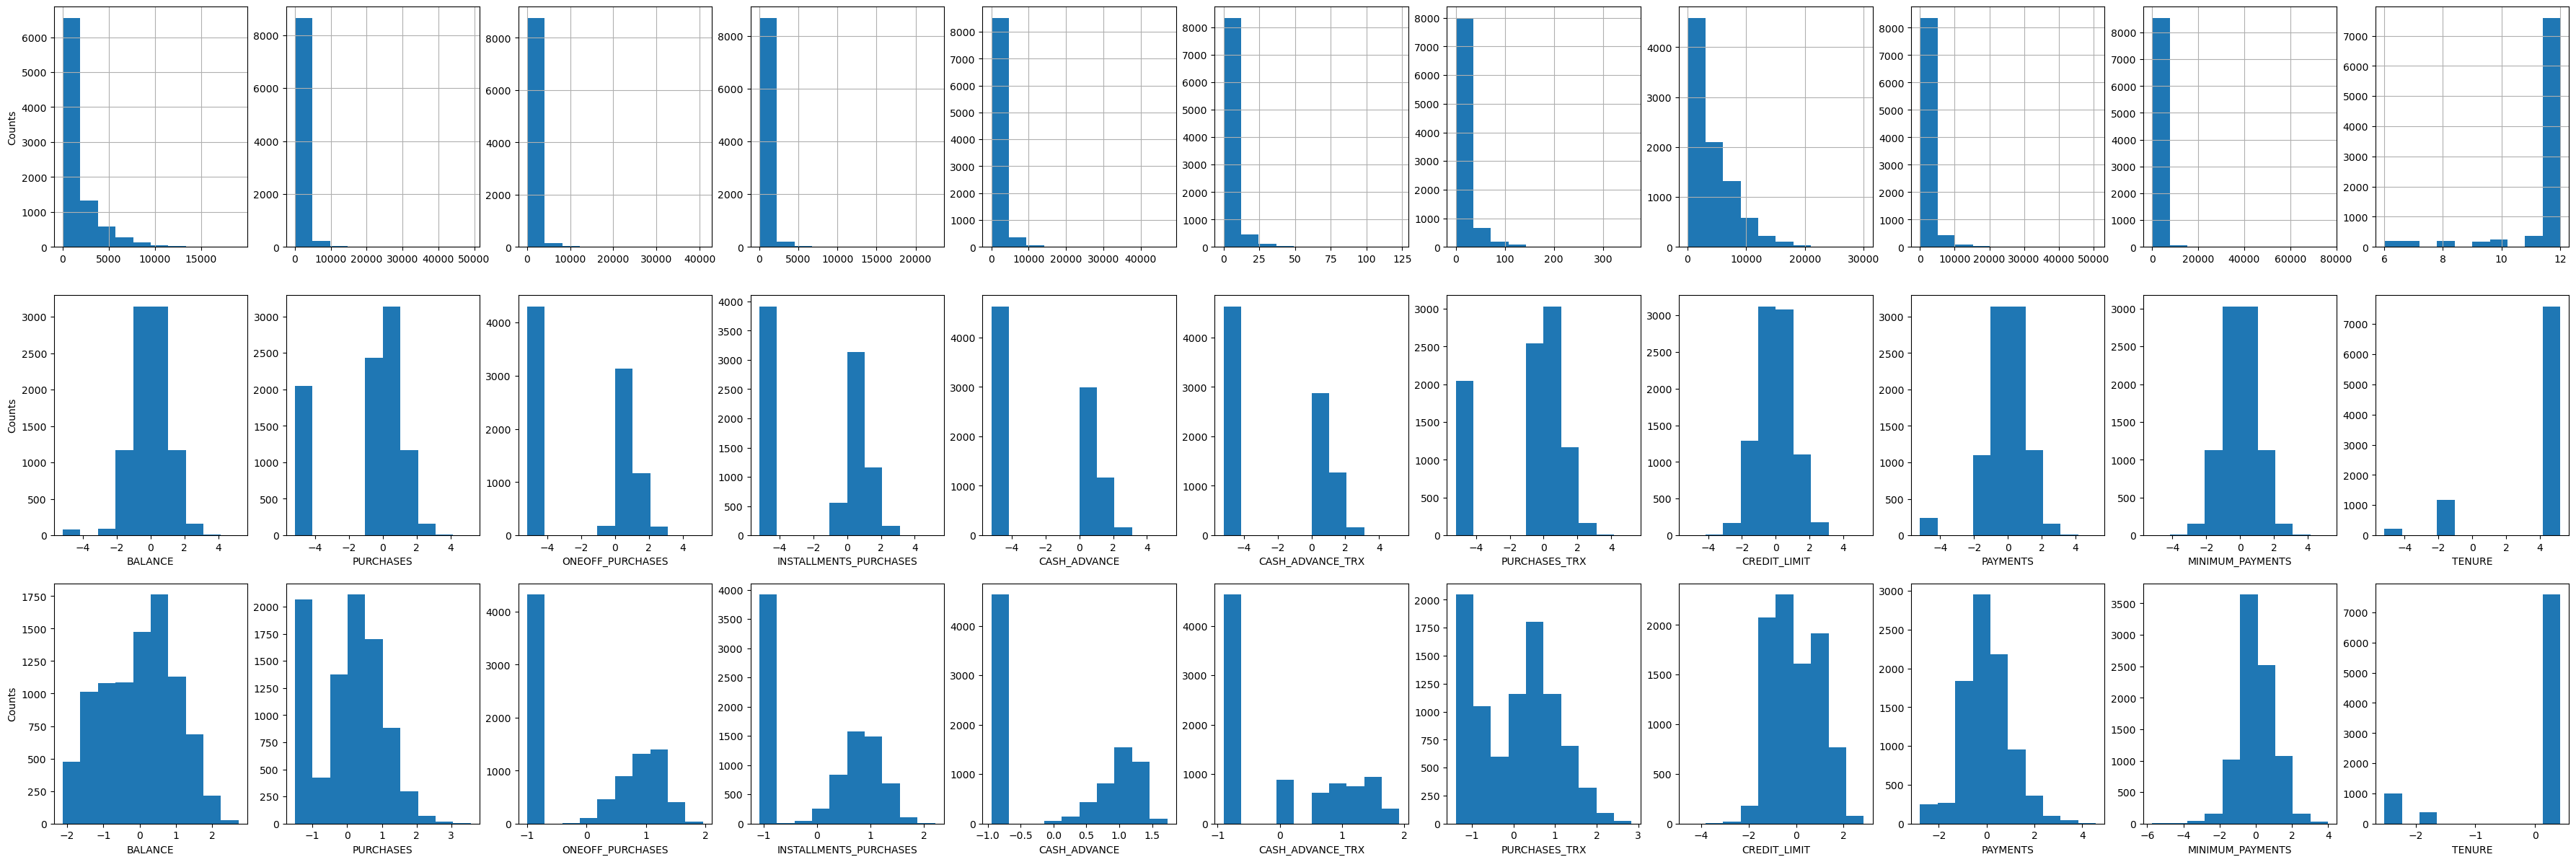

In [20]:
plt.rcParams['figure.figsize'] = [45, 15]
plt.rcParams['figure.dpi']=100
qt = QuantileTransformer(output_distribution='normal')
pt = PowerTransformer()
#qt.fit_transform()

iter=0
#for k in np.arange(0,1,1):
for j,col in enumerate(df_non_freq.drop(columns=['y_pred']).columns):
    #color = cm(1.*k/NUM_COLORS)
    iter+=1
    plt.subplot(3,11,iter)
    df_non_freq[col].hist()
    if j == 0:
        plt.ylabel('Counts')
               
for j,col in enumerate(df_non_freq.drop(columns=['y_pred']).columns):
    #color = cm(1.*k/NUM_COLORS)
    iter+=1
    plt.subplot(3,11,iter)
    plt.hist(qt.fit_transform(df_non_freq[col].values.reshape(-1, 1)))
    if j == 0:
        plt.ylabel('Counts')
    plt.xlabel(col)
    
for j,col in enumerate(df_non_freq.drop(columns=['y_pred']).columns):
    #color = cm(1.*k/NUM_COLORS)
    iter+=1
    plt.subplot(3,11,iter)
    plt.hist(pt.fit_transform(df_non_freq[col].values.reshape(-1, 1)))
    if j == 0:
        plt.ylabel('Counts')
    plt.xlabel(col)


I dont think we want to transform the tenure column as I'm not sure how much sense that makes intuitively. In that case, we will probably leave the column as is and then use the scaler. Looking at the power transformer, we have fewer of those spikes at a low value (which probably correspond to the zero values. We will use the powertransformer and redo the scaling and clustering; see if that helps. I expect MinMaxScaler to be better now since we are introducing negative values into this data.

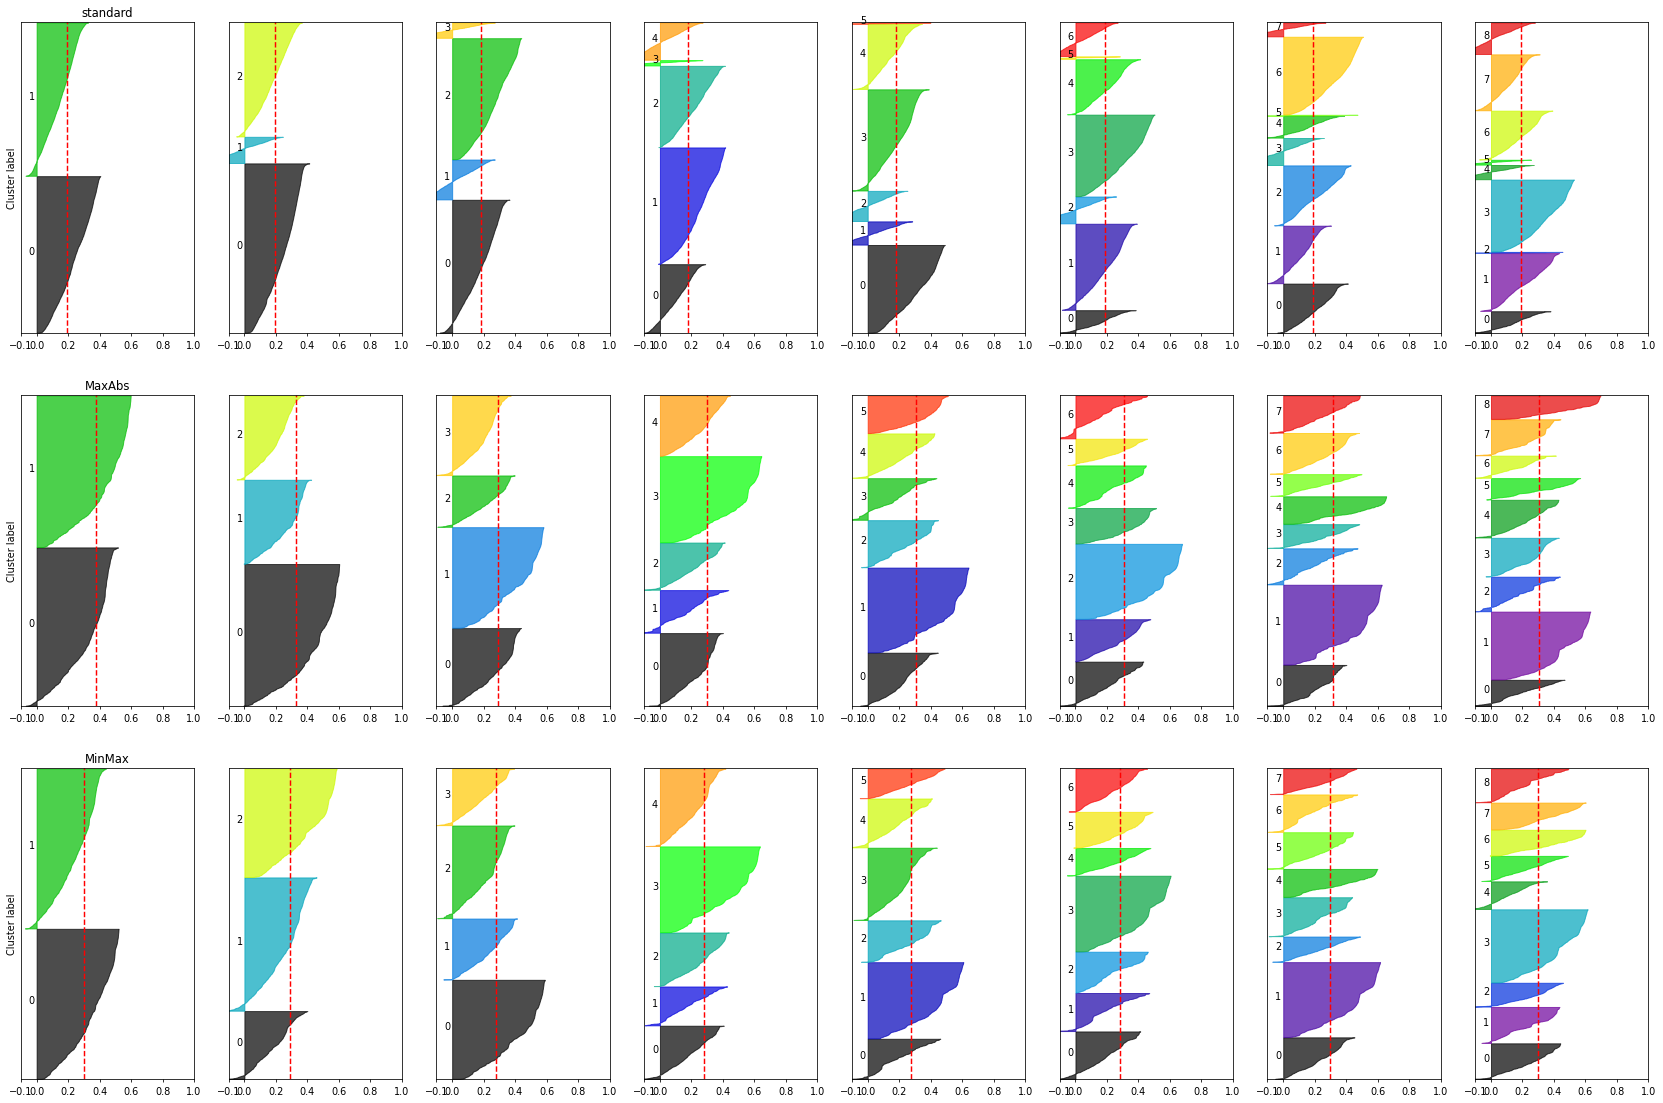

In [21]:
scalers=[StandardScaler(),MaxAbsScaler(),MinMaxScaler()]
titles = ['standard','MaxAbs','MinMax']
val=1
sse=[]

df_power = df.drop(columns=['y_pred'])

pt = PowerTransformer()
df_power[["BALANCE_FREQUENCY","PURCHASES_FREQUENCY","ONEOFF_PURCHASES_FREQUENCY","PURCHASES_INSTALLMENTS_FREQUENCY","CASH_ADVANCE_FREQUENCY","PRC_FULL_PAYMENT"]] = pt.fit_transform(df_power[["BALANCE_FREQUENCY","PURCHASES_FREQUENCY","ONEOFF_PURCHASES_FREQUENCY","PURCHASES_INSTALLMENTS_FREQUENCY","CASH_ADVANCE_FREQUENCY","PRC_FULL_PAYMENT"]])


for idx,scaler in enumerate(scalers):
    
    pipe = make_pipeline(KNNImputer(),scaler)
    X = pipe.fit_transform(df_power)
    plt.rcParams['figure.figsize'] = [30, 20]
    plt.rcParams['figure.dpi'] = 70
    y=np.array([])
    range_n_clusters = np.arange(2,10,1)
    
    for idx_n,n_clusters in enumerate(range_n_clusters):
        km_model = KMeans(n_clusters=n_clusters).fit(X)
        cluster_labels = km_model.predict(X)
        sse.append(km_model.inertia_)

        silhouette_avg = silhouette_score(X, cluster_labels)
        #print("For n_clusters =", n_clusters,
        #      "The average silhouette_score is :", silhouette_avg)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        
        plt.subplot(len(scalers),len(range_n_clusters),val)
        val+=1
        plt.xlim([-0.1, 1])
        plt.ylim([0, len(X) + (n_clusters + 1) * 10])


        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        #plt.set_title("The silhouette plot for the various clusters.")
        #plt.xlabel("The silhouette coefficient values")
        #plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        #plt.title(("Silhouette analysis for KMeans clustering on sample data "
                      #"with n_clusters = %d"),
                     #fontsize=14, fontweight='bold')
        if idx_n == 0:
            plt.ylabel("Cluster label")
            plt.title(titles[idx])
        if idx == 3:
            plt.xlabel("The silhouette coefficient values")
                

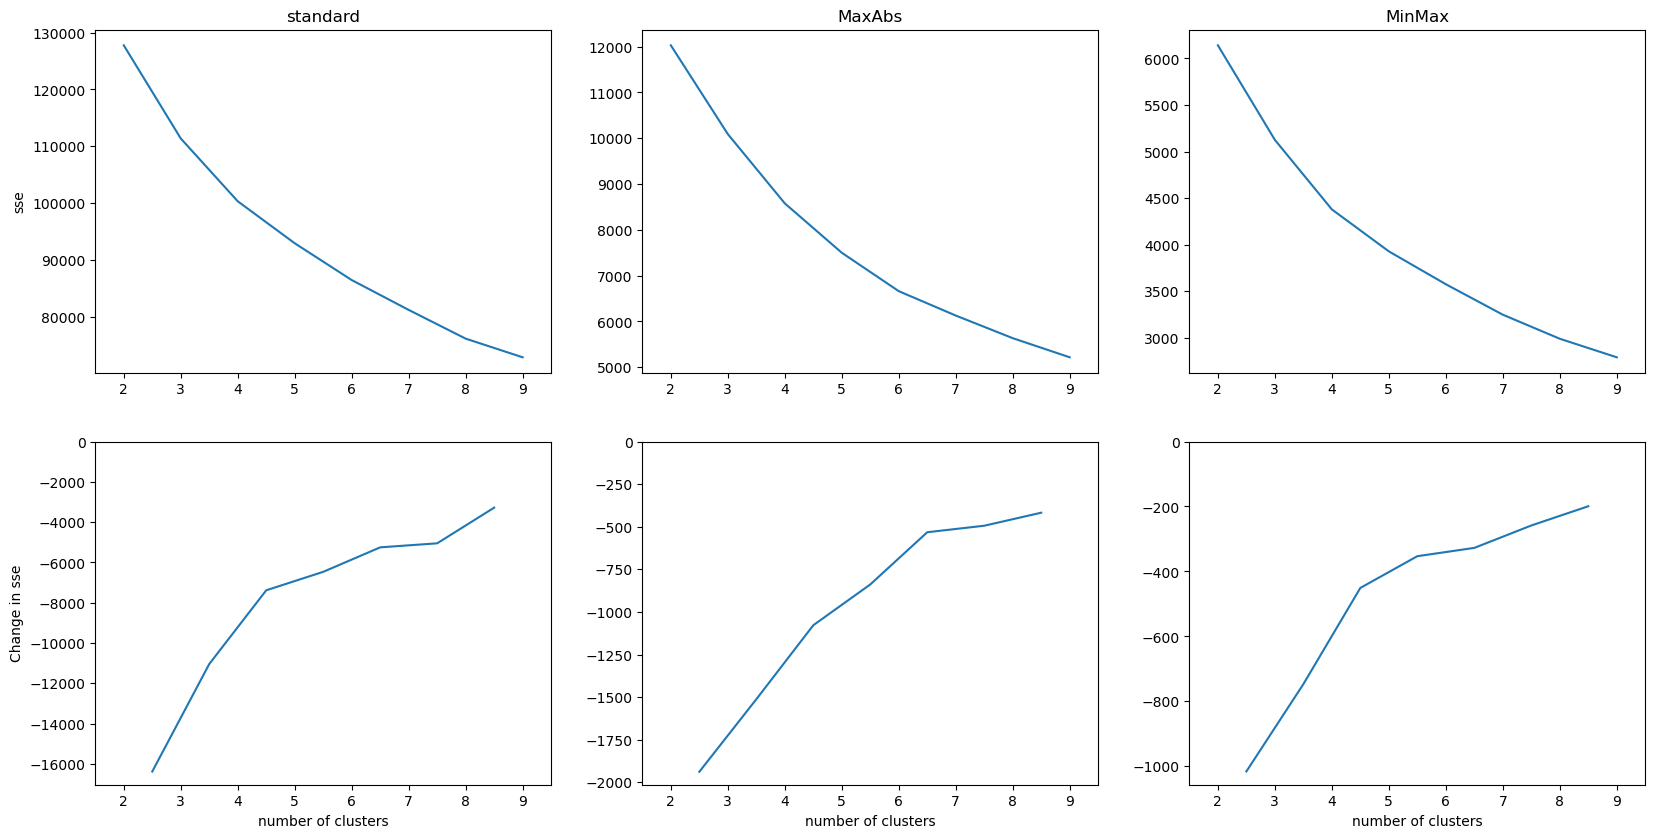

In [22]:
sse_plot =np.array(sse).reshape(3,8)
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 100
for k in range(0,3):
    plt.subplot(2,3,k+1)
    plt.plot(range_n_clusters,sse_plot[k,:])
    plt.title(titles[k])
    if k == 0:
        plt.ylabel('sse')
    plt.xlim([1.5,9.5])
    plt.subplot(2,3,k+1+3)
    plt.plot(range_n_clusters[:-1]+0.5,np.diff(sse_plot[k,:]))
    plt.xlabel('number of clusters')
    if k == 0:
        plt.ylabel('Change in sse')
    plt.xlim([1.5,9.5])
    plt.ylim(top=0)

Explained variance for the first three components are:
[39.54193226 19.96300245 13.12800461]
Cumulative Explained variance for the first three components are:
[39.54193226 59.50493472 72.63293933]


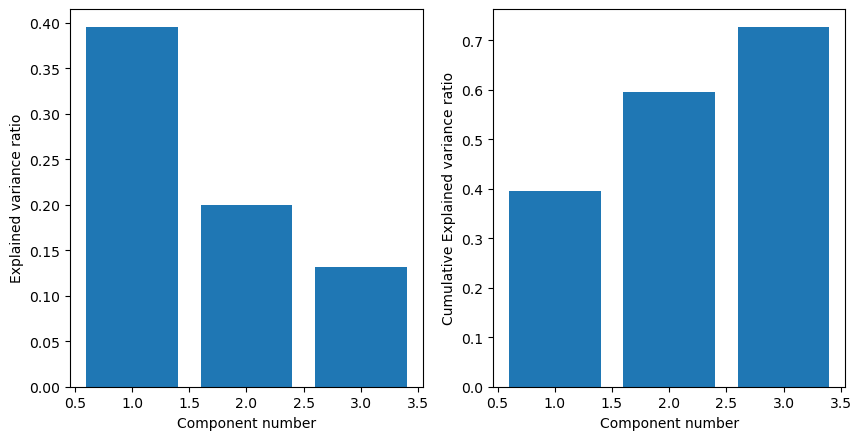

In [23]:
plt.rcParams['figure.figsize'] = [10, 5]

n_components = 3
n_clusters=7
pca = PCA(n_components=n_components)
X_r = pca.fit_transform(X) #We can just use X here because it was the final scaler tested in the pipeline earlier. Otherwise, I would write a new pipeline with all the steps included.

km_model = KMeans(n_clusters=n_clusters).fit(X)
y = km_model.predict(X)

plt.subplot(1,2,1)
plt.bar(np.arange(1,n_components+1,1),pca.explained_variance_ratio_)
plt.xlabel('Component number')
plt.ylabel('Explained variance ratio')

plt.subplot(1,2,2)
plt.bar(np.arange(1,n_components+1,1),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Component number')
plt.ylabel('Cumulative Explained variance ratio')

print('Explained variance for the first three components are:')
print(pca.explained_variance_ratio_*100)
print('Cumulative Explained variance for the first three components are:')
print(np.cumsum(pca.explained_variance_ratio_*100))

Text(0.5, 0, 'PC3')

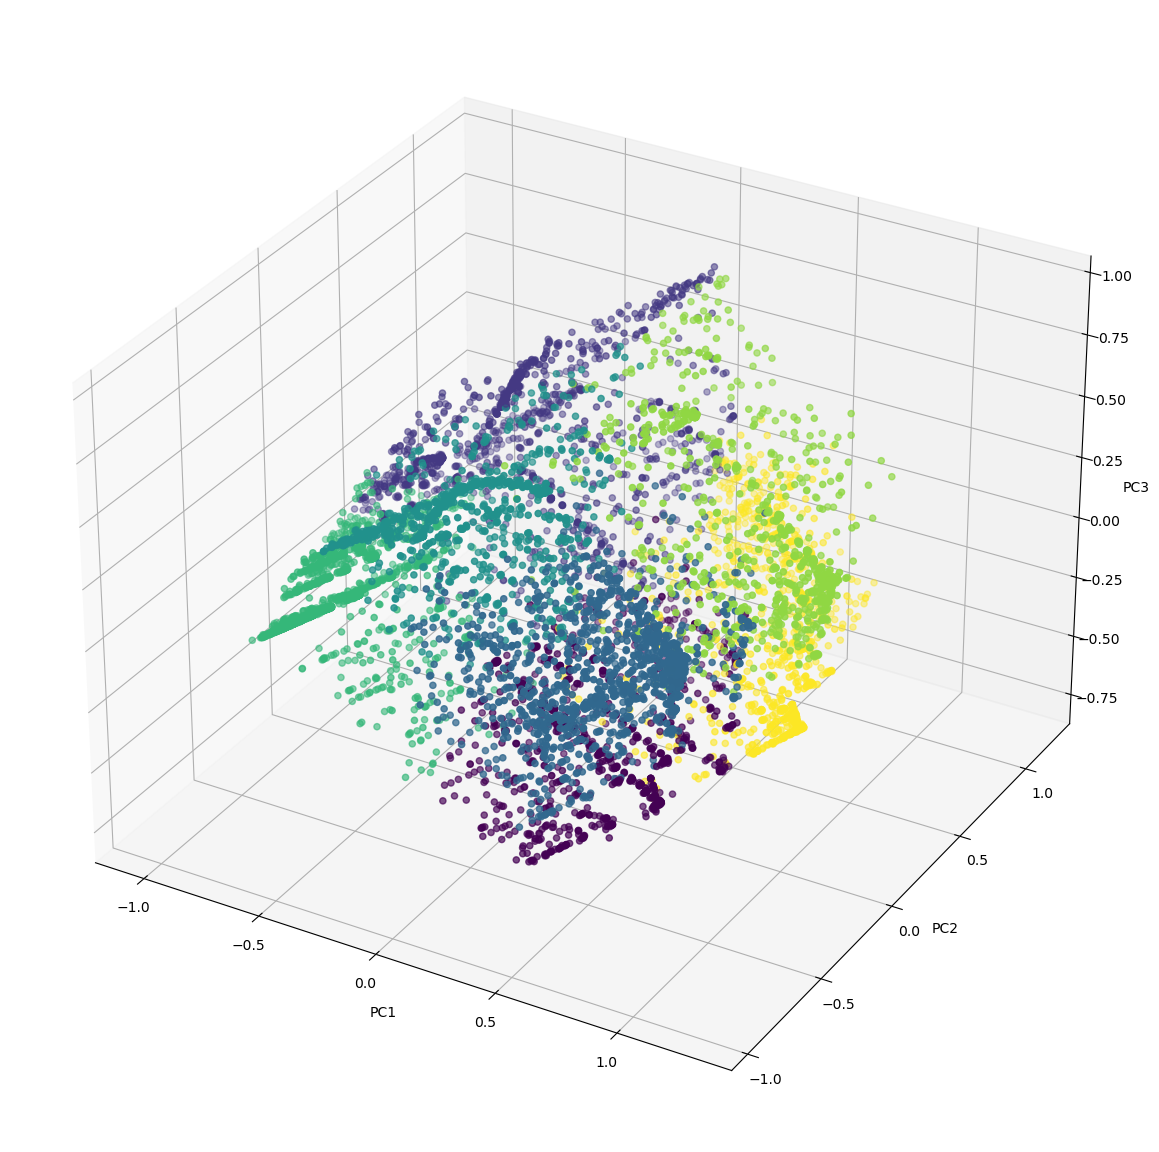

In [24]:
plt.rcParams['figure.figsize'] = [15, 15]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_r[:,0],X_r[:,1],X_r[:,2],c=y,marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

In [25]:
df['y_pred']=y
df_freq=df[["BALANCE_FREQUENCY","PURCHASES_FREQUENCY","ONEOFF_PURCHASES_FREQUENCY","PURCHASES_INSTALLMENTS_FREQUENCY",
                  "CASH_ADVANCE_FREQUENCY","PRC_FULL_PAYMENT","y_pred"]]
df_non_freq = df.drop(columns=["BALANCE_FREQUENCY","PURCHASES_FREQUENCY","ONEOFF_PURCHASES_FREQUENCY","PURCHASES_INSTALLMENTS_FREQUENCY",
                  "CASH_ADVANCE_FREQUENCY","PRC_FULL_PAYMENT"])

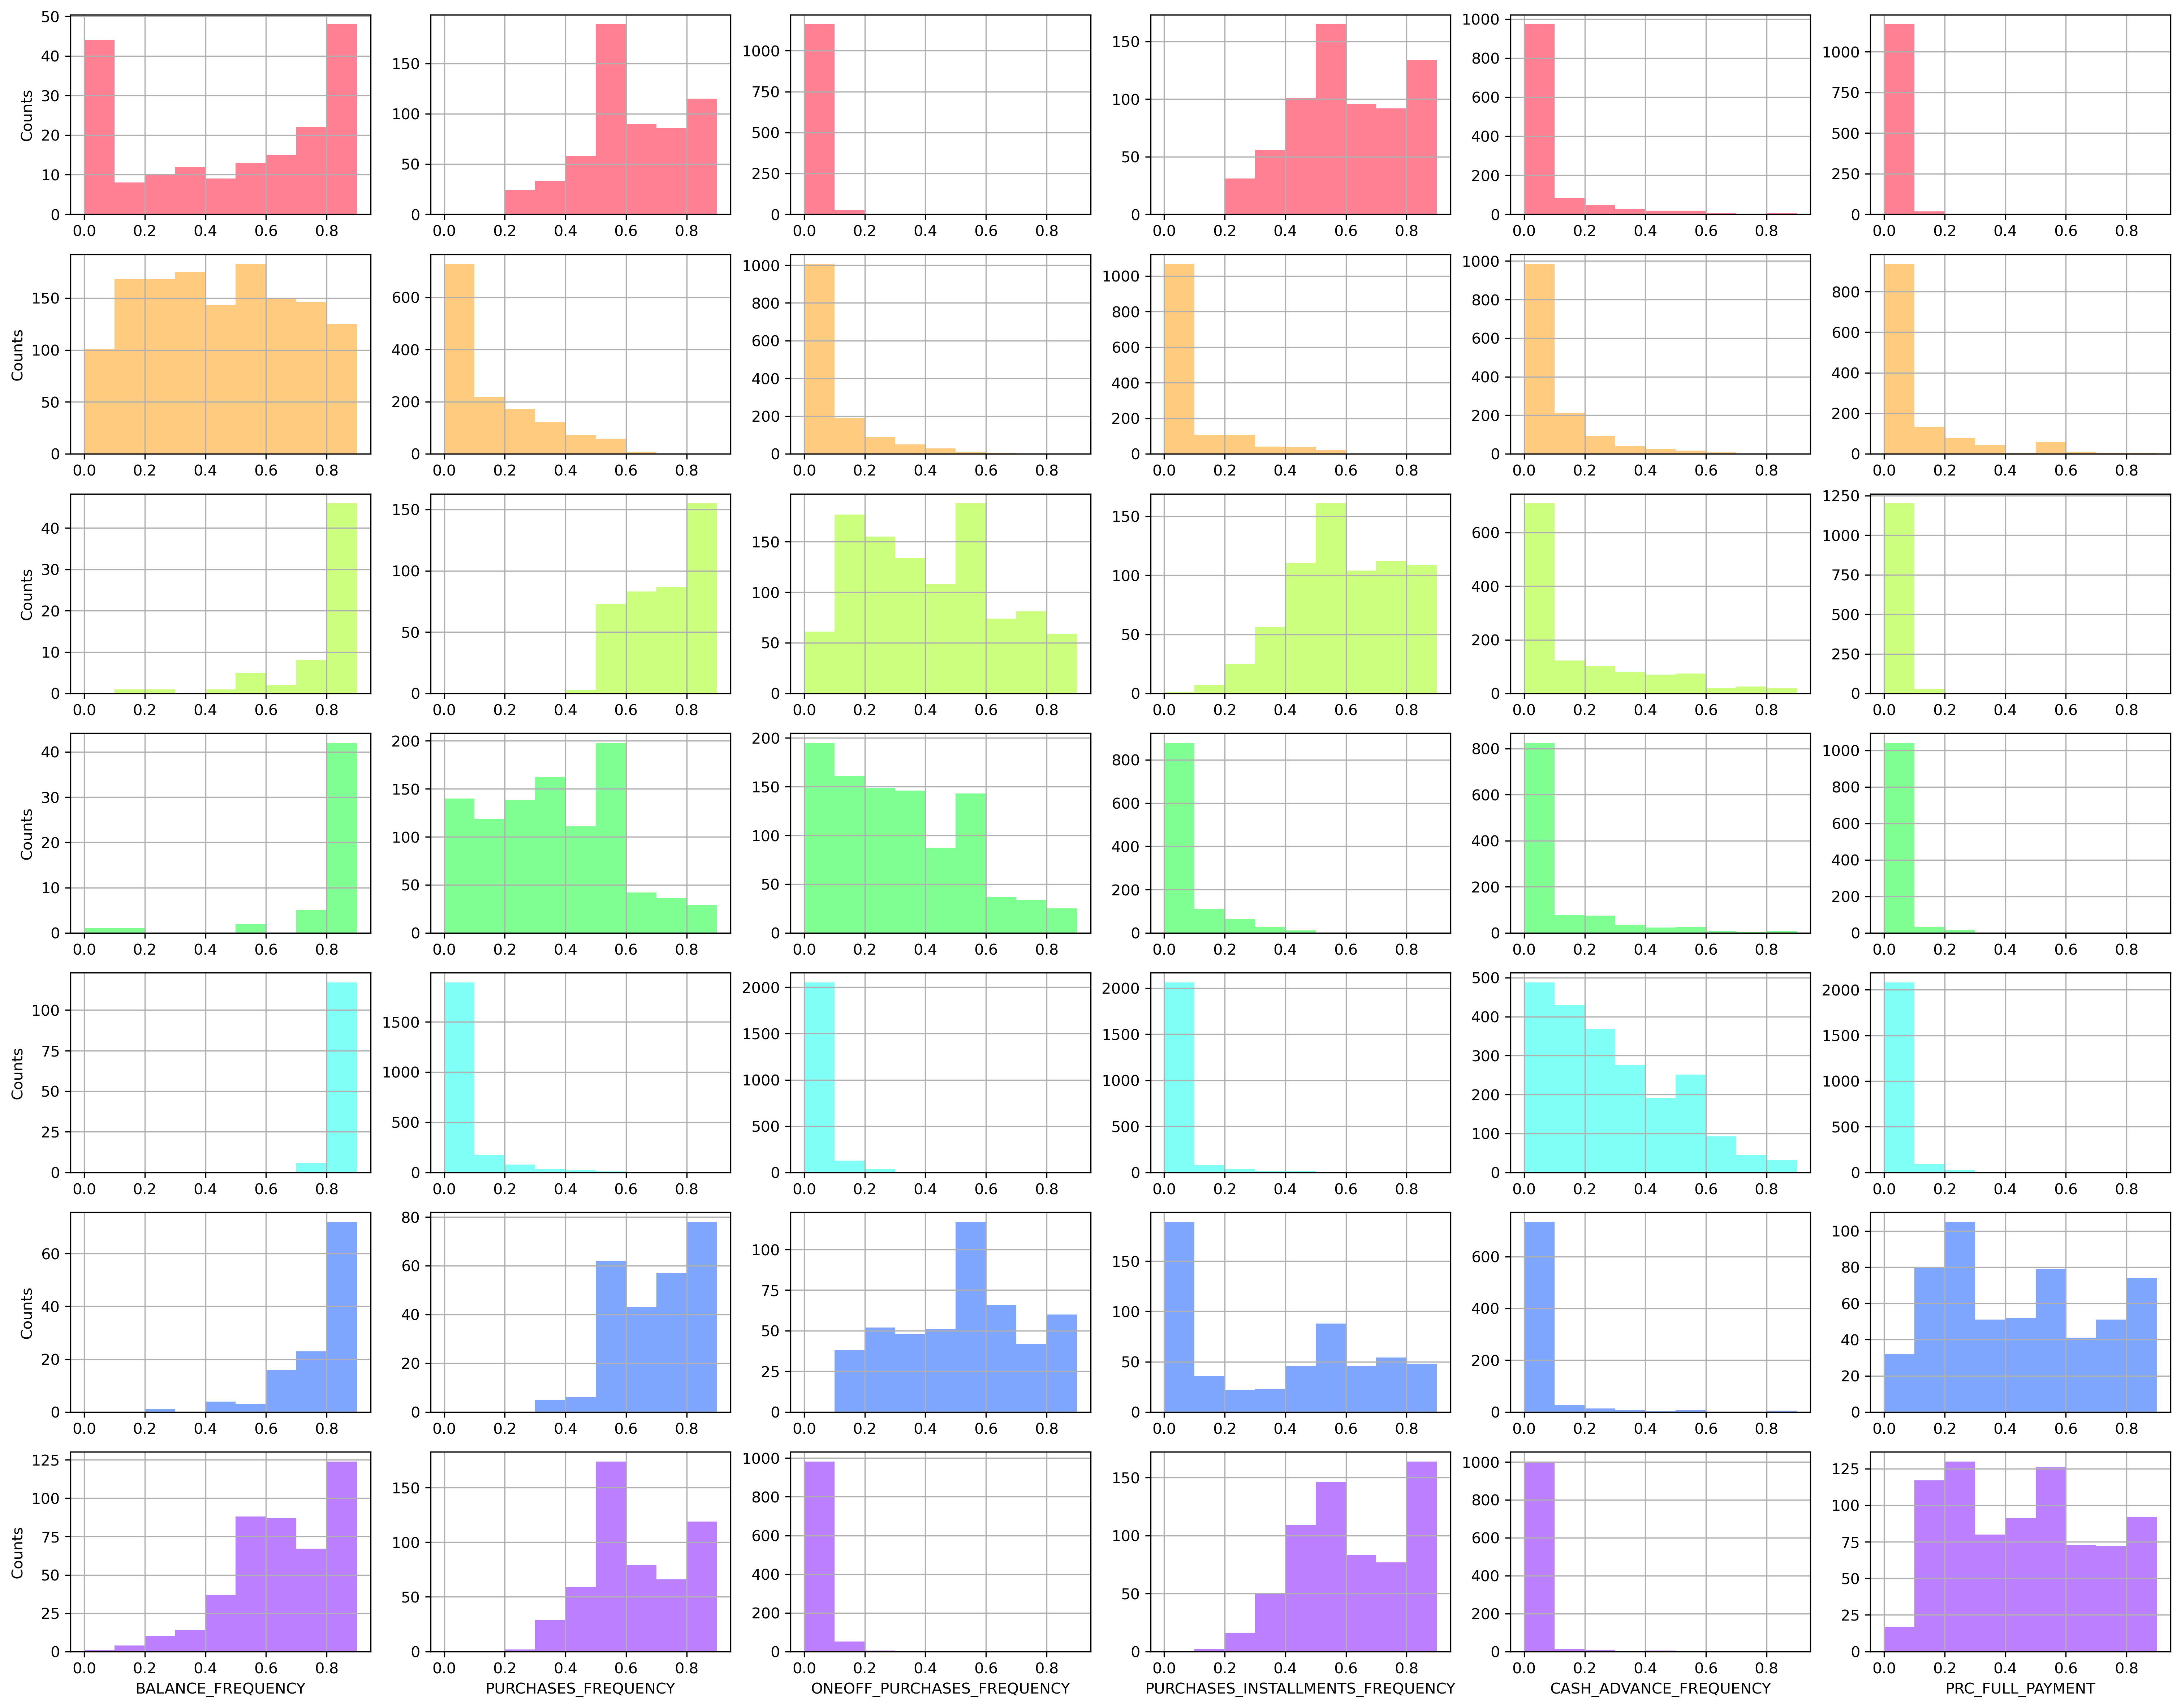

In [26]:
plt.rcParams['figure.figsize'] = [25, 20]
plt.rcParams['figure.dpi'] = 300
NUM_COLORS = 7
iter=0
colm = pylab.get_cmap('gist_rainbow')
for k in np.arange(0,7,1):
    for j,col in enumerate(df_freq.drop(columns=['y_pred']).columns):
        color = colm(1.*k/NUM_COLORS)
        iter+=1
        plt.subplot(7,6,iter)
        df[col].loc[df['y_pred']==k].hist(color=color,bins=np.arange(0,1,0.1),alpha=0.5)
        if j == 0:
            plt.ylabel('Counts')
        if k == 6:
            plt.xlabel(col)

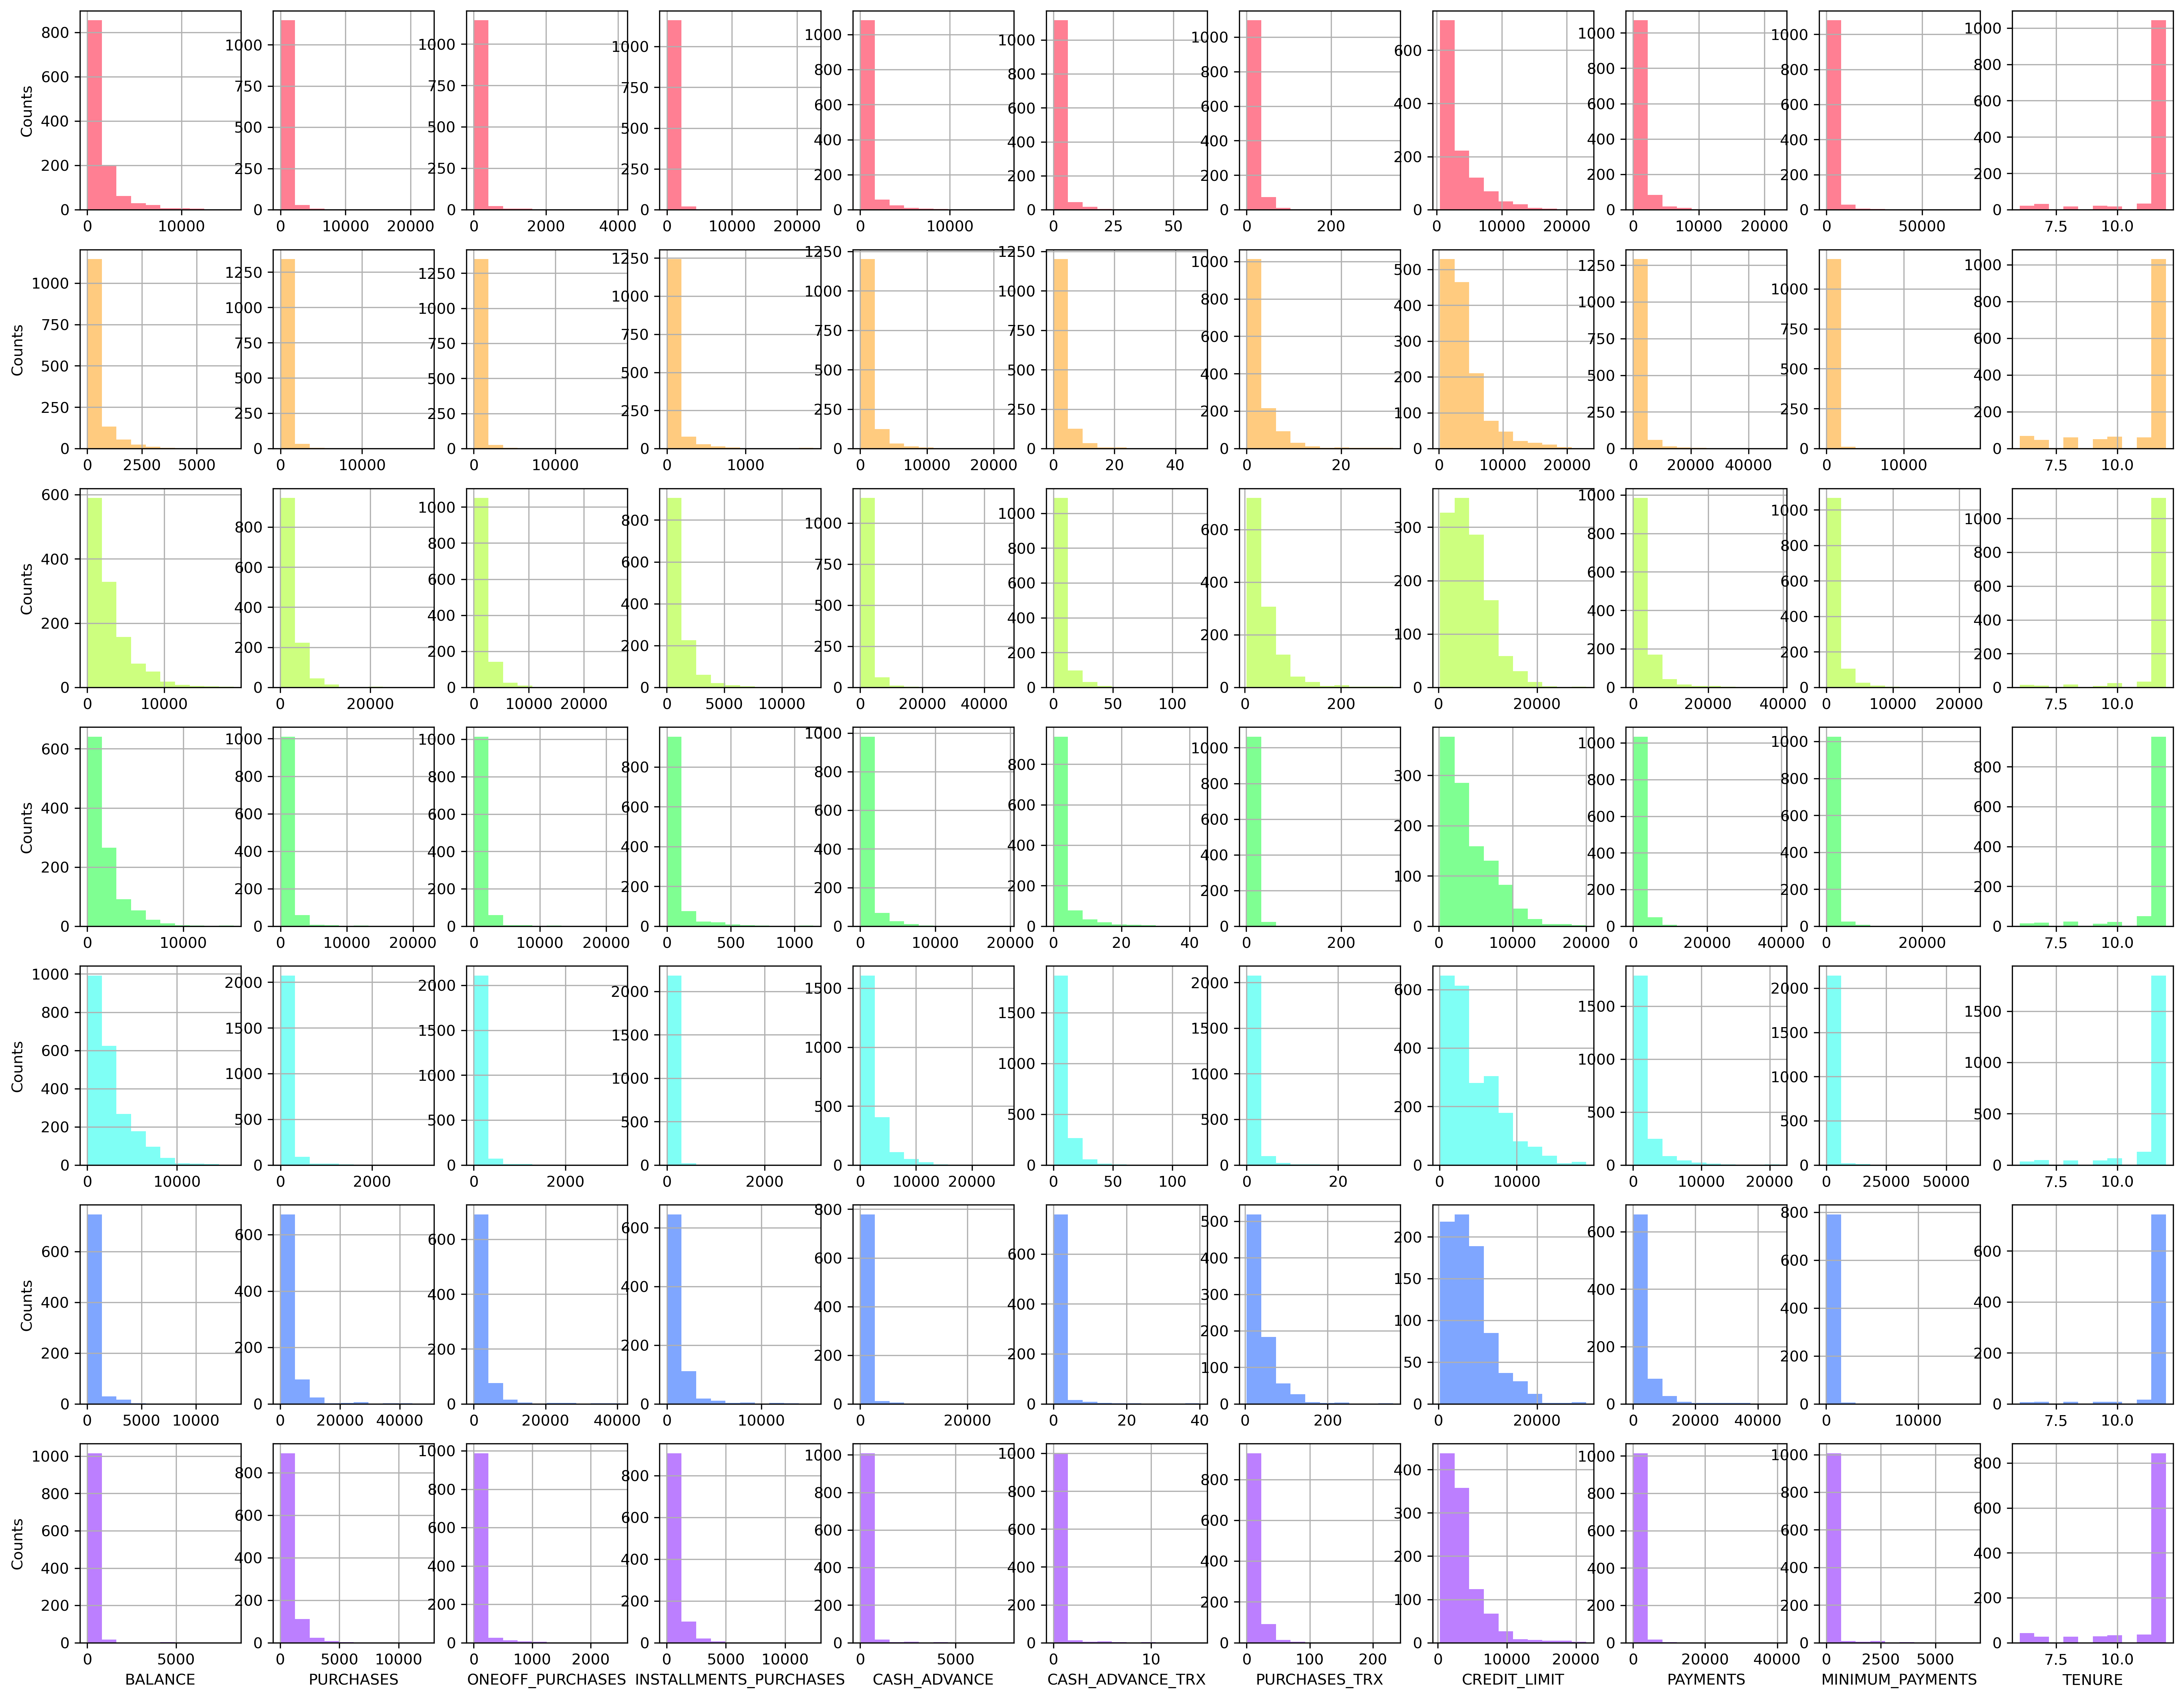

In [27]:
NUM_COLORS = 7
iter=0
colm = pylab.get_cmap('gist_rainbow')
for k in np.arange(0,7,1):
    for j,col in enumerate(df_non_freq.drop(columns=['y_pred']).columns):
        color = colm(1.*k/NUM_COLORS)
        iter+=1
        plt.subplot(7,11,iter)
        df[col].loc[df['y_pred']==k].hist(color=color,alpha=0.5)
        if j == 0:
            plt.ylabel('Counts')
        if k == 6:
            plt.xlabel(col)

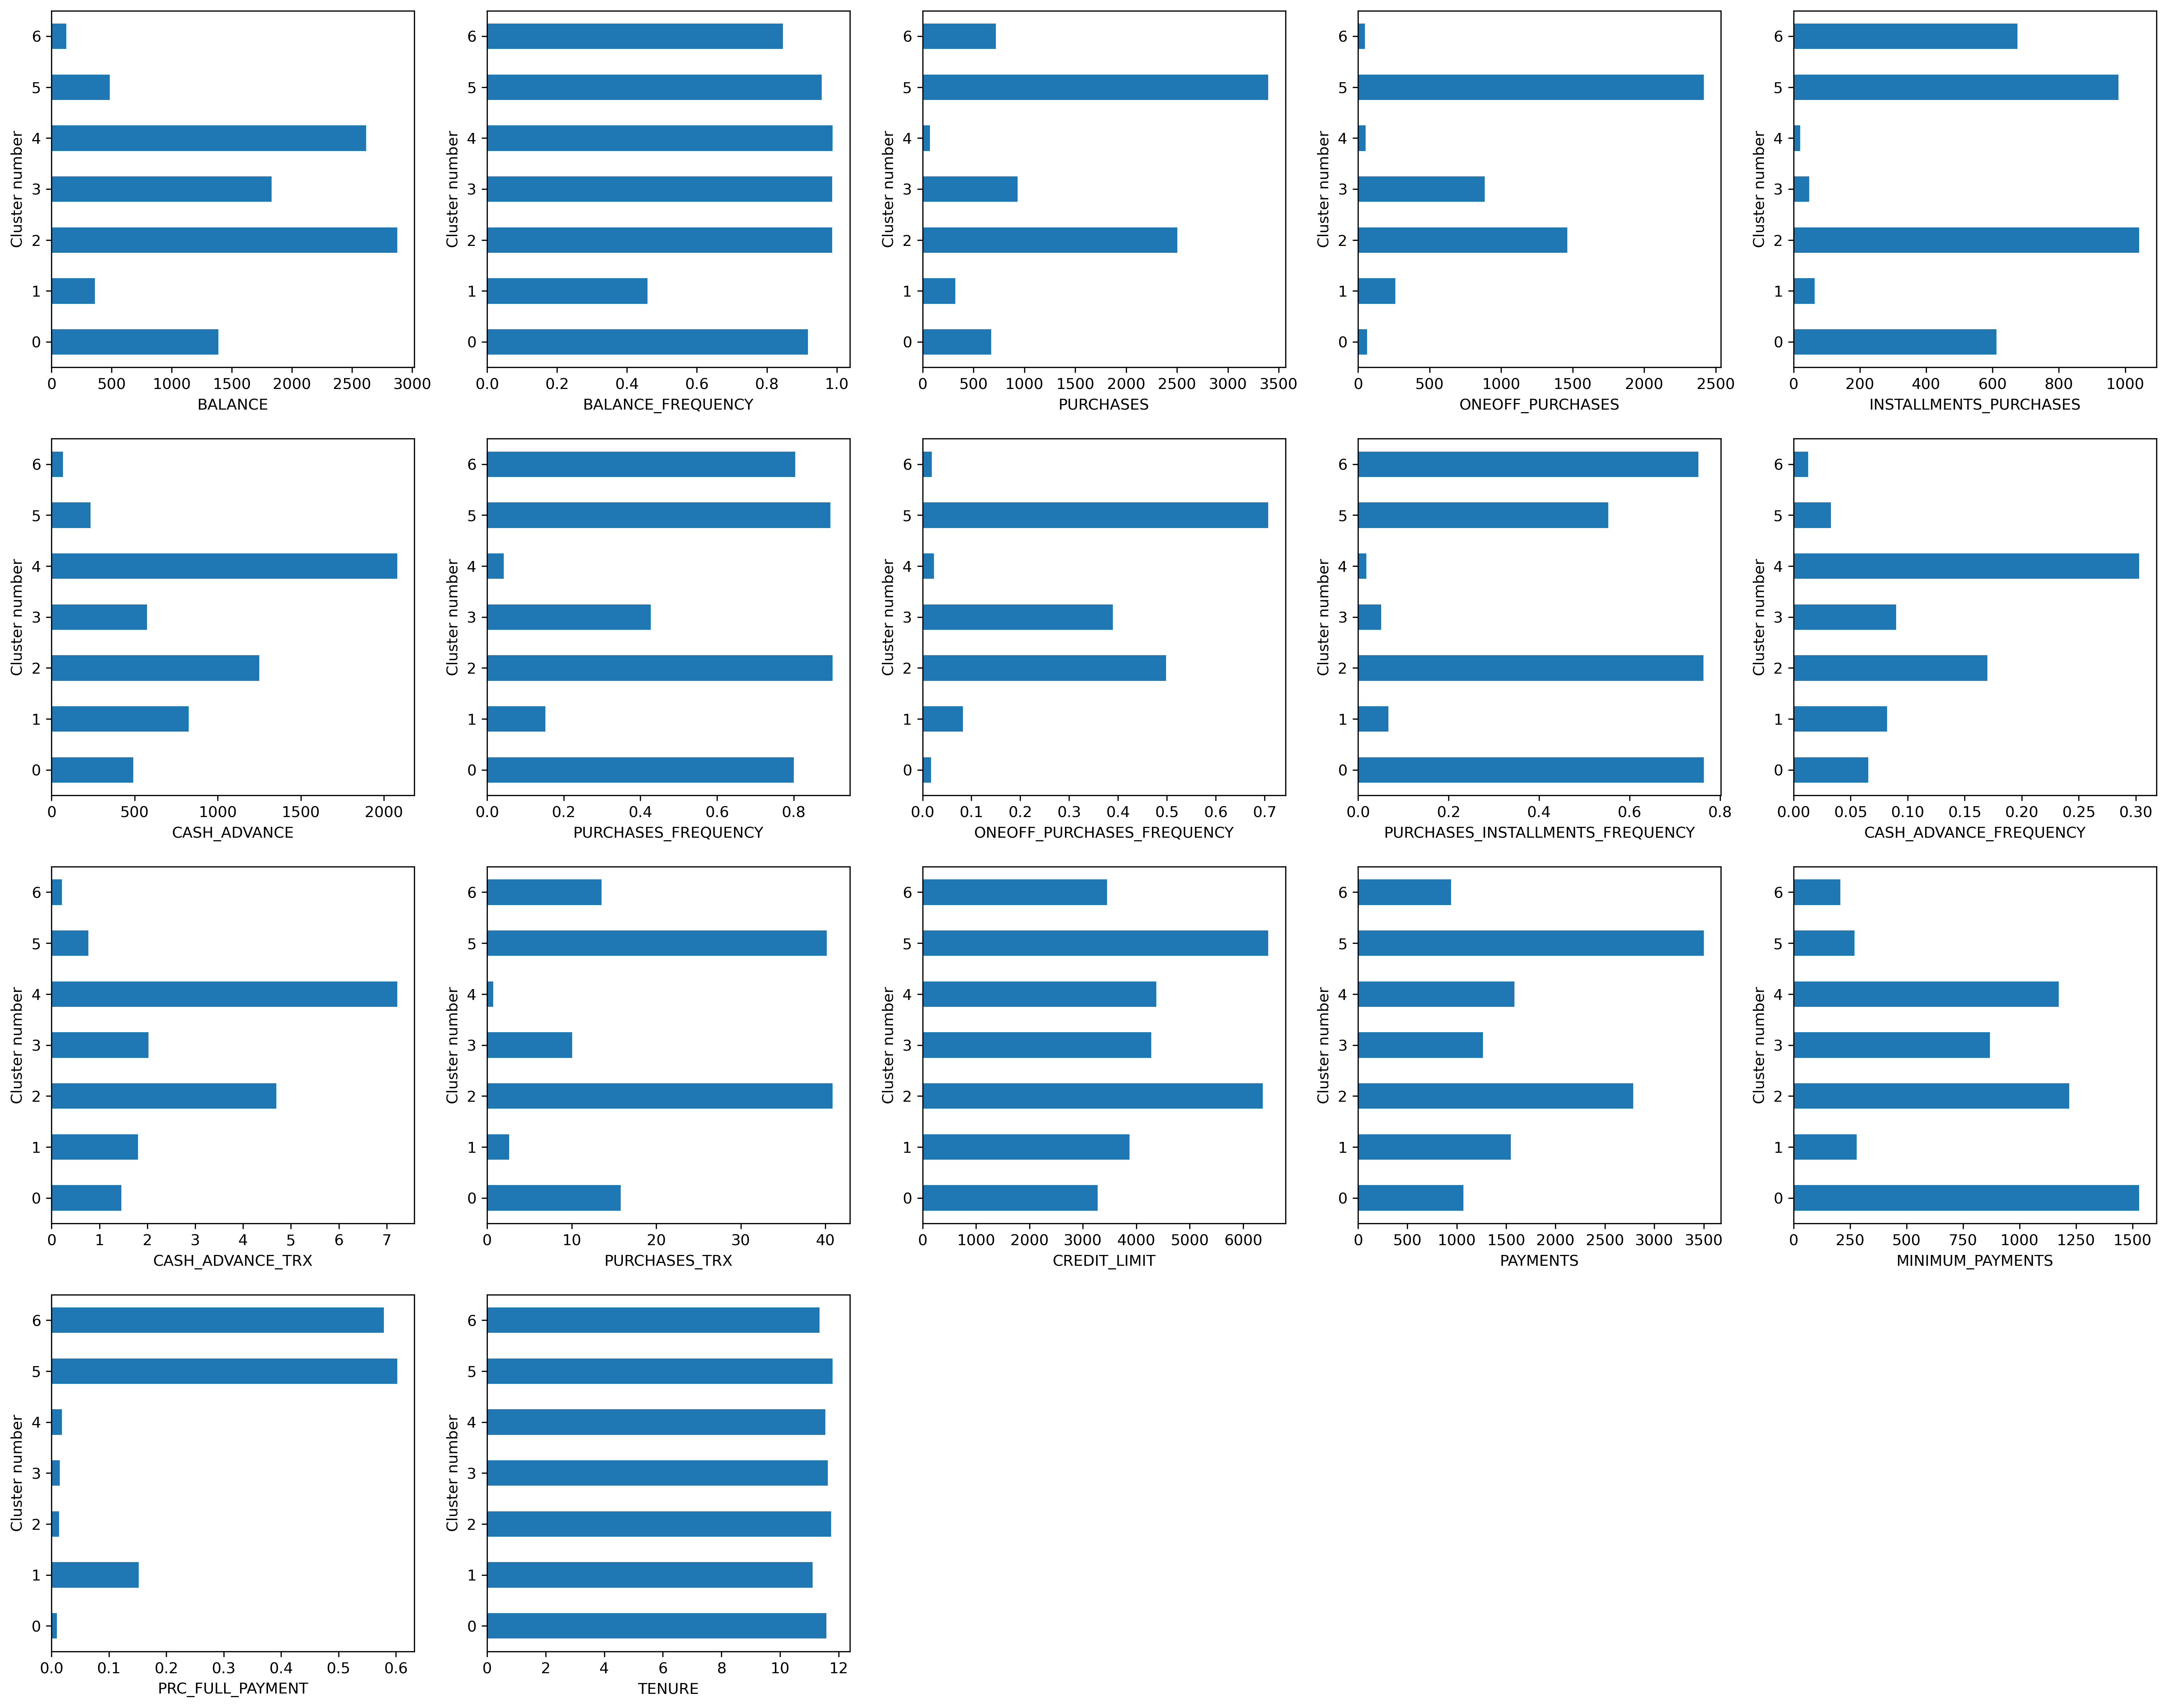

In [28]:
for iter,cols in enumerate(df.columns[:-1]):
    plt.subplot(4,5,iter+1)
    df.groupby('y_pred')[cols].mean().plot(kind='barh')
    plt.xlabel(cols)
    plt.ylabel('Cluster number')
    
    

In [29]:
df.groupby('y_pred').median()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
y_pred                                                                
0        931.907808           1.000000     430.54              0.00   
1         66.995516           0.454545      91.36              0.00   
2       2015.554911           1.000000    1791.11            912.70   
3       1254.216950           1.000000     589.24            542.49   
4       1834.543529           1.000000       0.00              0.00   
5        250.758639           1.000000    2196.00           1332.96   
6         47.107274           0.909091     454.20              0.00   

        INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
y_pred                                                              
0                       399.60      0.000000             0.900000   
1                         0.00      0.000000             0.083333   
2                       673.67    103.179579             1.000000   
3                         0.00      0.000000             0.333333   
4                         0.00   1247.803895             0.000000   
5                       527.14      0.000000             1.000000   
6                       428.90      0.000000             0.888889   

        ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
y_pred                                                                 
0                         0.000000                          0.833333   
1                         0.000000                          0.000000   
2                         0.416667                          0.833333   
3                         0.333333                          0.000000   
4                         0.000000                          0.000000   
5                         0.750000                          0.583333   
6                         0.000000                          0.833333   

        CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
y_pred                                                                          
0                     0.000000                 0             12        2000.0   
1                     0.000000                 0              1        3000.0   
2                     0.083333                 1             30        6000.0   
3                     0.000000                 0              7        3000.0   
4                     0.250000                 5              0        3000.0   
5                     0.000000                 0             29        6000.0   
6                     0.000000                 0             11        2500.0   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
y_pred                                                           
0        630.186926        468.332077          0.000000      12  
1        467.971285        137.064172          0.000000      12  
2       1692.635777        691.597386          0.000000      12  
3        716.004245        456.684218          0.000000      12  
4        820.261997        592.801847          0.000000      12  
5       2218.376164        179.875598          0.625000      12  
6        519.307161        150.940292          0.555556      12

In [30]:
df.groupby('y_pred').mean()

BALANCE  BALANCE_FREQUENCY    PURCHASES  ONEOFF_PURCHASES  \
y_pred                                                                  
0       1386.956748           0.917719   674.094180         62.950168   
1        359.146400           0.458531   323.249819        259.937431   
2       2874.855896           0.986536  2504.419781       1462.313812   
3       1830.461303           0.986488   932.635302        886.110495   
4       2615.944815           0.988197    72.810939         53.338407   
5        484.937380           0.956726  3396.264443       2416.223880   
6        123.828750           0.845817   720.983985         46.974793   

        INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
y_pred                                                              
0                   612.087073    490.932629             0.800074   
1                    63.527149    825.534743             0.152281   
2                  1042.105969   1250.453776             0.901685   
3                    46.916639    574.955156             0.427238   
4                    19.527437   2079.246315             0.043928   
5                   980.040563    235.322016             0.895874   
6                   674.701184     68.330978             0.804068   

        ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
y_pred                                                                 
0                         0.017597                          0.763965   
1                         0.082760                          0.066844   
2                         0.498531                          0.763464   
3                         0.389757                          0.050840   
4                         0.023235                          0.018410   
5                         0.707251                          0.552990   
6                         0.019070                          0.752144   

        CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
y_pred                                                                          
0                     0.065371          1.458368      15.819176   3276.432109   
1                     0.081844          1.808249       2.634588   3873.949707   
2                     0.169909          4.695864      40.853204   6369.166114   
3                     0.090079          2.027473      10.083333   4277.014652   
4                     0.302936          7.218412       0.750000   4374.187726   
5                     0.032674          0.772215      40.163955   6468.081693   
6                     0.012926          0.218479      13.538980   3455.579131   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT     TENURE  
y_pred                                                              
0       1067.054693       1529.499239          0.009312  11.580320  
1       1546.730636        279.301941          0.151693  11.110709  
2       2787.851187       1219.261997          0.012973  11.742092  
3       1266.392700        868.783202          0.014133  11.633700  
4       1582.979278       1172.909592          0.018284  11.538809  
5       3500.065142        269.373504          0.602331  11.793492  
6        943.765386        207.024581          0.579234  11.338787